In [124]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from numpy import genfromtxt
import astropy.units as u
from astropy.constants import h, c, e
import math
hello = e
print(hello)
from astropy import constants as const

  Name   = Electron charge
  Value  = 1.602176634e-19
  Uncertainty  = 0.0
  Unit  = C
  Reference = CODATA 2018


In [125]:
#h = 6.62606957 * 10 ** (-34)
c0 = 299792458
charge = 1.602176634e-19
thickness = 1 * 10 ** (-5)

In [126]:
def GaussAmp(x, y0, A, x0, fwhm):
    w = fwhm/np.sqrt(np.log(4))
    exponential = ((x-x0)**2)/(2 * (w**2))
    y = y0 + A * np.exp(-exponential)
    return y

In [133]:
#make a bunch of useful functions
def zero_remover(data):  #Only for lists
    zero_removed_data = []
    for i in range(0, len(data)):
        if data[i] > 0:
            zero_removed_data.append(data[i])
        else:
            zero_removed_data.append(0)
    zero_removed_data = np.array(zero_removed_data)
    return zero_removed_data


def csv_to_numpy(csv_file):
    all_data = genfromtxt(csv_file, delimiter=",", dtype=float, missing_values=["NaN", "#DIV/0!"], filling_values=0)
    all_data_removed_headers = all_data[2:, :]
    cleaned_data = np.where(all_data_removed_headers > 0, all_data_removed_headers, 0)
    return cleaned_data


def seperated_data(clean_data):
    wavelength = np.array(clean_data[:, 0]) * u.nm
    transmission0 = np.array(clean_data[:, 1])
    transmission100 = np.array(clean_data[:, 2])
    BA2PbI4 = np.array(clean_data[:, 3])
    SC_BA2MAPb2I7 = np.array(clean_data[:, 4])
    PC_BA2MAPb2I7 = np.array(clean_data[:, 5])

    #energy_J = h * c0 / (wavelength * (10 ** (-9)))
    #energy_eV = energy_J * u.J
    #energy_eV.to(u.eV)

    #wavelength = np.array(clean_data[:, 0]) * u.nm

    energy_eV = (h * c / wavelength).to(u.eV).value

    incident = transmission100 - transmission0
    BA2PbI4_background = BA2PbI4 - transmission0
    SC_BA2MAPb2I7_background = SC_BA2MAPb2I7 - transmission0
    PC_BA2MAPb2I7_background = PC_BA2MAPb2I7 - transmission0
    return energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background


def all_calcs(incident, material):
    tranmission_material = (material / incident) * 100  #is this absorpTance & visa versa?
        # Absorbance, safely handling divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        absorbance = np.log10(incident / material)
        absorbance[~np.isfinite(absorbance)] = 0  # set inf/nan to 0
    coefficient_literature = (np.log(10) / thickness) * absorbance
    return tranmission_material, absorbance, coefficient_literature


def transmissionPlot(wavelength, incident, Material_background, colour_index, key, key_index):
    tranmission_material, absorbance, coefficient_literature = all_calcs(incident, Material_background)

    index_add_value = key_index
    indexed_transmission_material = index_add_value + tranmission_material
    cmap = plt.cm.viridis
    colour = cmap(colour_index)
    plt.plot(wavelength, indexed_transmission_material, label=f"{key}h", color=colour, linewidth=2)
    return


def absorbancePlot(wavelength, incident, Material_background, colour_index, key, key_index):
    tranmission_material, absorbance, coefficient_literature = all_calcs(incident, Material_background)

    index_add_value = key_index
    indexed_transmission_material = index_add_value + absorbance
    cmap = plt.cm.viridis  #cmc.batlow.resampled(25)
    colour = cmap(colour_index)
    plt.plot(wavelength, indexed_transmission_material, label=f"{key}h", color=colour, linewidth=2)
    return


def AbsCoPlot(wavelength, incident, Material_background, colour_index, key, key_index):
    tranmission_material, absorbance, coefficient_literature = all_calcs(incident, Material_background)

    index_add_value = key_index
    indexed_transmission_material = index_add_value + coefficient_literature
    cmap = plt.cm.viridis  #cmc.batlow.resampled(25)
    colour = cmap(colour_index)
    plt.plot(wavelength, indexed_transmission_material, label=f"{key}h", color=colour, linewidth=2)
    return


def format_sig_fig(x, sig_fig):
    """
    Format a number x to sig_fig significant figures,
    preserving trailing zeros as decimal places when needed.
    """
    if x == 0:
        return f"{0:.{sig_fig}f}"  # just return 0.00... for consistency
    # Determine how many digits before decimal
    import math
    digits_before_decimal = int(math.floor(math.log10(abs(x)))) + 1
    decimals_needed = max(sig_fig - digits_before_decimal, 0)
    return f"{x:.{decimals_needed}f}"

In [186]:
#the God function
def InNominePatrisEtFiliiEtSpiritusSancti(dictionary, q1min, q1max, q2min, q2max, q3min, q3max, q4min, q4max, GraphOn=True, ParamsOn=True):
    ba2pbi4_parameters = [] #fwhm +- fwhm_err, x0 +- x0, A +- A_err, y0 +- y0_err
    sc_n2_parameters = [] #fwhm +- fwhm_err, x0 +- x0, A +- A_err, y0 +- y0_err
    sc_n3_parameters = [] #fwhm +- fwhm_err, x0 +- x0, A +- A_err, y0 +- y0_err
    pc_parameters = [] #fwhm +- fwhm_err, x0 +- x0, A +- A_err, y0 +- y0_err
    for key in dictionary.keys():
        if isinstance(key, tuple):
            time_heated, label = key
        else:
            time_heated = float(key)
            label = None
        #get the different bits of data
        energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background = seperated_data(dictionary[key])
        #print(energy_eV)
        #make the loops for all the data in the dictionary
        for name, i in [("BA2PbI4", BA2PbI4_background),
                        ("SC",      SC_BA2MAPb2I7_background),
                        ("PC",      PC_BA2MAPb2I7_background),]:
            #cut off the useless x axis bits
            start = h.value * c0 /((800 * 10 ** -9)* charge)
            end = h.value * c0/((450 * 10 ** -9)* charge)

            energy_eV_new = []
            i_new = []
            incident_new = []
            for m, energy in enumerate(energy_eV):
                if energy > start and energy < end:
                    energy_eV_new.append(energy)
                    i_new.append(i[m])
                    incident_new.append(incident[m])
                else:
                    continue

            #do further cuts for the peak fitting
            if name == "BA2PbI4":
                restricted_x = [1]
            elif name == "SC":
                restricted_x = [2, 3]
            elif name == "PC":
                restricted_x = [4]
            else:
                print("error ... error ... error ... error ... error ...")

            #this loop exists as I have a wonderful 2 different peaks in the same plot!!!
            for q in restricted_x:
                if q == 1:
                    xmin = q1min
                    xmax = q1max
                if q == 2:
                    xmin = q2min
                    xmax = q2max
                if q == 3:
                    xmin = q3min
                    xmax = q3max
                if q == 4:
                    xmin = q4min
                    xmax = q4max

                stupid_x_cut_for_stupid_fittings = []
                wait_I_have_to_do_this_for_y_as_well_insert_crying_face = []
                wait_I_have_to_do_more_Let_the_pain_end = []
                for bleh, energy in enumerate(energy_eV):
                    if energy > xmin and energy < xmax:
                        stupid_x_cut_for_stupid_fittings.append(energy)
                        wait_I_have_to_do_this_for_y_as_well_insert_crying_face.append(i[bleh])
                        wait_I_have_to_do_more_Let_the_pain_end.append(incident[bleh])
                    #else: #please dont ever go here code
                        #print("cry and give up for the rest of the day")
                        #continue #bleh

                trans, abs, absco = all_calcs(np.asarray(wait_I_have_to_do_more_Let_the_pain_end), np.asarray(wait_I_have_to_do_this_for_y_as_well_insert_crying_face))
                cleaned_abs = []
                for x in abs:
                    if isinstance(x, (int, float)) and (math.isnan(x) or math.isinf(x)):
                        cleaned_abs.append(0)
                    else:
                        cleaned_abs.append(x)
                trans_plot, abs_plot, absco_plot = all_calcs(np.asarray(incident_new), np.asarray(i_new))
                #print(i)

                # your initial guesses
                y0 = 0
                A = 2
                x0 = 2.4
                fwhm = 0.1
                #p0 = [A0, EG0, EB0, test]
                p0 = [y0, A, x0, fwhm]

                try:
                    params, covariance = curve_fit(GaussAmp, stupid_x_cut_for_stupid_fittings, cleaned_abs, maxfev=100000, p0=p0)
                except RuntimeError as e:
                    print(f"Fit failed at {key}")
                    continue  # move to next loop iteration

                # Uncertainties (1σ standard deviations)
                (y0_err, A_err, x0_err, fwhm_err) = np.sqrt(np.diag(covariance))
                y0, A, x0, fwhm = params

                if name == "BA2PbI4":
                    material = r"BA$_{2}$PbI$_{4}$"
                    peak = r"n=1"
                elif name == "SC":
                    material = r"SC BA$_{2}$MAPb$_{2}$I$_{7}$"
                    if q==2:
                        peak = r"n=2"
                    elif q==3:
                        peak = r"n=3"
                    else:
                        peak = r"I, the python programme you wrote, wants your tears."
                elif name == "PC":
                    material = r"PC BA$_{2}$MAPb$_{2}$I$_{7}$"
                    peak = r"n=2"
                time_heated = key
                title = f"{material} heated for {time_heated}h"
                legend = f"plot"
                if GraphOn == True:
                    plt.title(title)
                    plt.plot(energy_eV_new, abs_plot, label=legend)
                    plt.plot(energy_eV_new, GaussAmp(energy_eV_new, *params), label=f"{peak} phase fit")
                    plt.legend()
                    plt.xlim(h.value * c.value/(800 * const.e.value * 10 **-9), h.value * c.value/(450 * const.e.value * 10 **-9))
                    plt.ylim(0, 3)
                    plt.show()
                else:
                    continue
                if ParamsOn == True:
                    print(f"FWHM = {fwhm:.4f} ± {fwhm_err:.4f}")
                    print(f"x0 = {x0:.4f} ± {x0_err:.4f}")
                    print(f"A = {A:.4f} ± {A_err:.4f}")
                    print(f"y0 = {y0:.4f} ± {y0_err:.4f}")
                else:
                    continue
                if name == "BA2PbI4":
                    ba2pbi4_parameters.append(
                        [time_heated, fwhm, fwhm_err, x0, x0_err, A, A_err, y0, y0_err])
                #elif np.array_equal(i, SC_BA2MAPb2I7_background):
                    #for q in restricted_x:
                        #if q==2:
                            #sc_n2_parameters.append([time_heated, fwhm,fwhm_err, x0,x0_err, A,A_err, y0,y0_err])
                        #elif q==3:
                            #sc_n3_parameters.append([time_heated, fwhm,fwhm_err, x0,x0_err, A,A_err, y0,y0_err])
                        #else:
                            #print("You have found a peak in the Single Crystal BA2MAPb2I7 that does not exist, congratulations on this impeccable achievement")
                elif name == "SC":
                    if q == 2:
                        sc_n2_parameters.append([time_heated, fwhm, fwhm_err, x0, x0_err, A, A_err, y0, y0_err])
                    elif q == 3:
                        sc_n3_parameters.append([time_heated, fwhm, fwhm_err, x0, x0_err, A, A_err, y0, y0_err])
                    else:
                        print("You have found a peak in the Single Crystal BA2MAPb2I7 that does not exist, congratulations on this impeccable achievement")
                elif name == "PC":
                    pc_parameters.append([time_heated, fwhm, fwhm_err, x0, x0_err, A, A_err, y0, y0_err])
                else:
                    print("you have somehow plotted somethign that does not exist")
    print("Optimisation parameters stored")
    return ba2pbi4_parameters, sc_n2_parameters, sc_n3_parameters, pc_parameters

In [187]:
#Load in the data
directory = r"A:\Y4 Project code\Data\Raw data"
# Use glob to find all CSV files (recursively if needed)
csv_files = glob.glob(os.path.join(directory, "*.csv"))

data_dict1 = {}

for file in csv_files:
    key = os.path.splitext(os.path.basename(file))[0]
    #print(key)
    key = key.replace("Easy access data - ", "", 1) #format == key.replace("old bit of key", "new bit of key", "counts(if counts == 1 then replaces all instances)")
    #print(key)
    short_key = key.split(" - ")[0].strip()
    short_key = short_key.split(" -")[0].strip()
    short_key = short_key.split("-")[0].strip() # remove everything after the "-" in the item called "short_key"

    short_key = short_key.replace("m", "",1)
    short_key = short_key.replace(" heat", "",1)

    hours = int(short_key.split("h")[0].strip())
    #print(hours, "hours")
    minutes = int(short_key.split("h")[1].strip()) if len(short_key) > 1 and short_key.split("h")[1].strip() else 0
    #print(minutes, "minutes")
    if minutes > 30:
        hours = hours + 1

    #print(short_key)
    #print(key)
    data_dict1[str(hours)] = csv_to_numpy(file)
print(data_dict1.keys())
#print(data_dict["0"][:, 0])
#print(data_dict["0"][:, 1])
#print(data_dict["0"][:, 2])
#print(data_dict["0"][:, 3])
#print(data_dict["0"][:, 4])
#print(data_dict["0"][:, 5])

#the order of the keys is in the awful ['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'] order. We need to fix that
key_list = []
for key in data_dict1.keys():
    key_list.append(int(key))
    correct_key_order = np.argsort(key_list)
print(correct_key_order)


correct_keys = []

for key in correct_key_order:
    correct_keys.append(key_list[key])


new_dict = {}

for key in correct_keys:
    new_dict[str(key)] = data_dict1[str(key)]
data_dict1 = new_dict
print(data_dict1.keys()) #viola!

dict_keys(['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'])
[ 0  6  8 10 11 12 13 14  1  2  3  4  5  7  9]
dict_keys(['0', '1', '21', '26', '44', '50', '67', '73', '139', '162', '167', '185', '192', '209', '215'])


In [188]:
#Load in the data
directory = r"A:\Y4 Project code\Data\Raw data sample 3"
# Use glob to find all CSV files (recursively if needed)
csv_files = glob.glob(os.path.join(directory, "*.csv"))
data_dict3 = {}

for file in csv_files:
    key1 = os.path.splitext(os.path.basename(file))[0]

    key = key1.replace("Easy access data - ", "",
                       1)  #format == key.replace("old bit of key", "new bit of key", "counts(if counts == 1 then replaces all instances)")
    key = key.replace("Sample set 3 - ", "", 1)
    #print(key)
    short_key = key.split(" - ")[0].strip()
    short_key = short_key.split(" -")[0].strip()
    short_key = short_key.split("-")[0].strip()  # remove everything after the "-" in the item called "short_key"

    short_key = short_key.replace("m", "", 1)
    short_key = short_key.replace(" heat", "", 1)

    #print(short_key)
    #placeholder = float(short_key.split("h")[0].strip())
    # extract numeric time
    time_hours = float(short_key.split("h")[0].strip())

    # extract day or file tag
    label = "day2" if "(day2)" in key1 else "day1"

    data_dict3[(time_hours, label)] = csv_to_numpy(file)
    #print(time_hours)

#print(data_dict.keys())
#print(data_dict["0"][:, 0])
#print(data_dict["0"][:, 1])
#print(data_dict["0"][:, 2])
#print(data_dict["0"][:, 3])
#print(data_dict["0"][:, 4])
#print(data_dict["0"][:, 5])

#the order of the keys is in the awful ['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'] order. We need to fix that
key_list = []
for key in data_dict3.keys():
    #key1 = float(key)
    key_list.append(key[0])
correct_key_order = np.argsort(key_list)
#print(correct_key_order)

correct_keys = []

keys_as_list = list(data_dict3.keys())
for idx in correct_key_order:
    correct_keys.append(keys_as_list[idx])

new_dict = {}

for key in correct_keys:
    new_dict[key] = data_dict3[key]
data_dict3 = new_dict
print(data_dict3.keys())  #viola!

dict_keys([(0.0, 'day1'), (0.5, 'day1'), (1.0, 'day1'), (1.5, 'day1'), (2.5, 'day1'), (3.0, 'day1'), (4.0, 'day1'), (5.0, 'day1'), (5.5, 'day2'), (5.5, 'day1'), (6.5, 'day2'), (7.5, 'day2'), (8.5, 'day2'), (9.5, 'day2'), (10.0, 'day2')])


In [189]:
#Load in the data
directory = r"A:\Y4 Project code\Data\Raw data sample 4"
# Use glob to find all CSV files (recursively if needed)
csv_files = glob.glob(os.path.join(directory, "*.csv"))

data_dict4 = {}

for file in csv_files:
    key = os.path.splitext(os.path.basename(file))[0]
    #print(key)
    key = key.replace("Sample 4 raw data - ", "", 1) #format == key.replace("old bit of key", "new bit of key", "counts(if counts == 1 then replaces all instances)")
    #print(key)
    short_key = key.split(" - ")[0].strip()
    short_key = short_key.split(" -")[0].strip()
    short_key = short_key.split("-")[0].strip() # remove everything after the "-" in the item called "short_key"

    short_key = short_key.replace("m", "",1)
    short_key = short_key.replace(" heat", "",1)

    hours = int(short_key.split("h")[0].strip())
    #print(hours, "hours")
    #minutes = int(short_key.split("h")[1].strip()) if len(short_key) > 1 and short_key.split("h")[1].strip() else 0
    #print(minutes, "minutes")
    #if minutes > 30:
        #hours = hours + 1

    #print(short_key)
    #print(key)
    data_dict4[str(hours)] = csv_to_numpy(file)
print(data_dict4.keys())
#print(data_dict["0"][:, 0])
#print(data_dict["0"][:, 1])
#print(data_dict["0"][:, 2])
#print(data_dict["0"][:, 3])
#print(data_dict["0"][:, 4])
#print(data_dict["0"][:, 5])

#the order of the keys is in the awful ['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'] order. We need to fix that
key_list = []
for key in data_dict4.keys():
    key_list.append(int(key))
    correct_key_order = np.argsort(key_list)
print(correct_key_order)


correct_keys = []

for key in correct_key_order:
    correct_keys.append(key_list[key])


new_dict = {}

for key in correct_keys:
    new_dict[str(key)] = data_dict4[str(key)]
data_dict4 = new_dict
print(data_dict4.keys()) #viola!

dict_keys(['0'])
[0]
dict_keys(['0'])


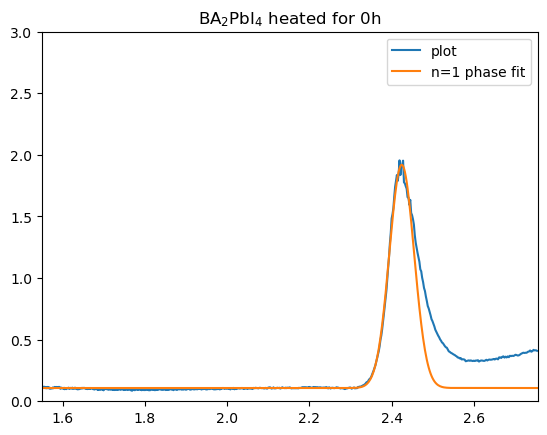

FWHM = 0.0353 ± 0.0002
x0 = 2.4244 ± 0.0002
A = 1.8122 ± 0.0058
y0 = 0.1077 ± 0.0016


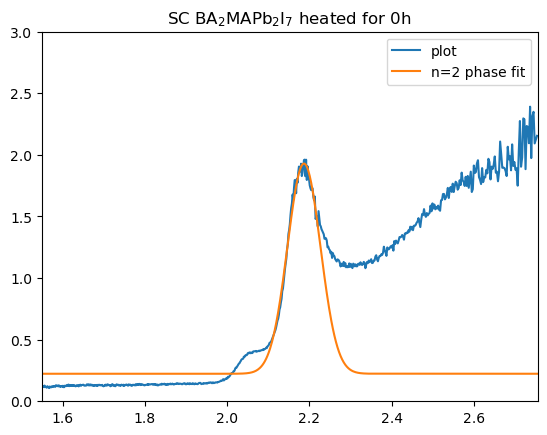

FWHM = 0.0471 ± 0.0015
x0 = 2.1868 ± 0.0005
A = 1.7063 ± 0.0441
y0 = 0.2234 ± 0.0480


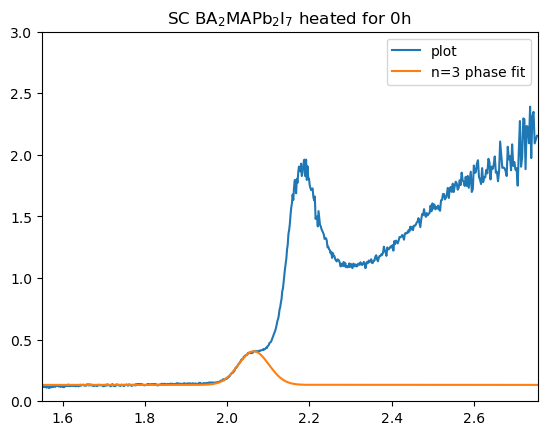

FWHM = 0.0433 ± 0.0013
x0 = 2.0646 ± 0.0008
A = 0.2729 ± 0.0054
y0 = 0.1330 ± 0.0054


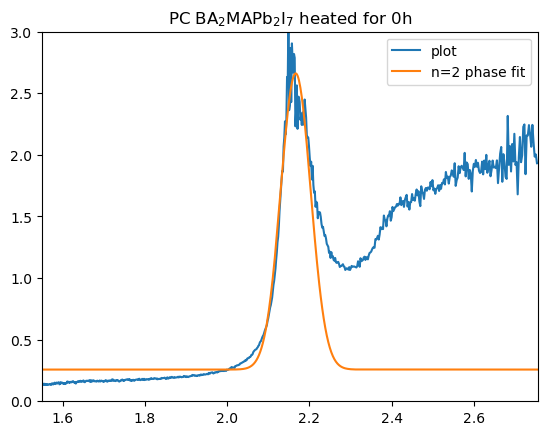

FWHM = 0.0428 ± 0.0008
x0 = 2.1667 ± 0.0006
A = 2.4042 ± 0.0251
y0 = 0.2574 ± 0.0104


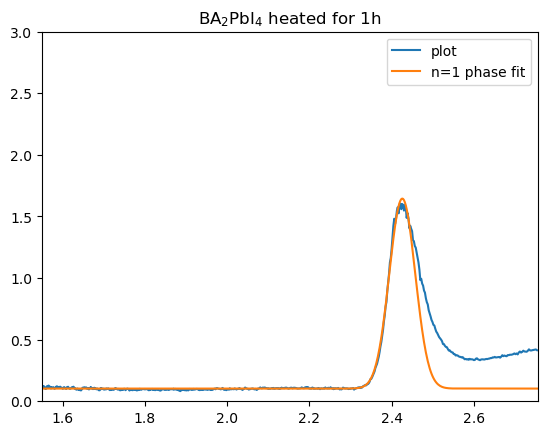

FWHM = 0.0370 ± 0.0002
x0 = 2.4258 ± 0.0002
A = 1.5424 ± 0.0052
y0 = 0.1031 ± 0.0014


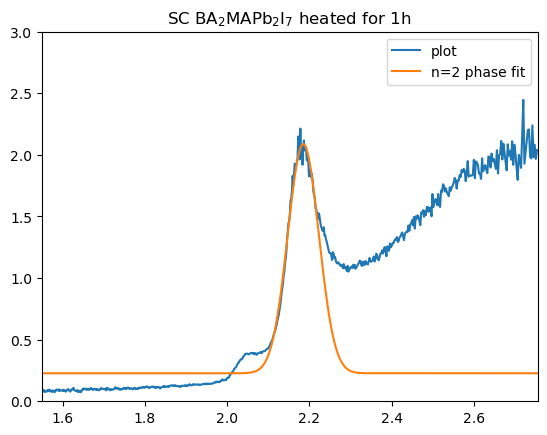

FWHM = 0.0445 ± 0.0013
x0 = 2.1853 ± 0.0004
A = 1.8600 ± 0.0433
y0 = 0.2273 ± 0.0470


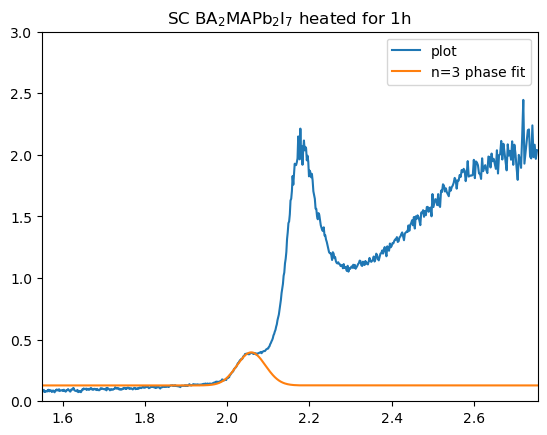

FWHM = 0.0406 ± 0.0015
x0 = 2.0587 ± 0.0007
A = 0.2683 ± 0.0068
y0 = 0.1286 ± 0.0072


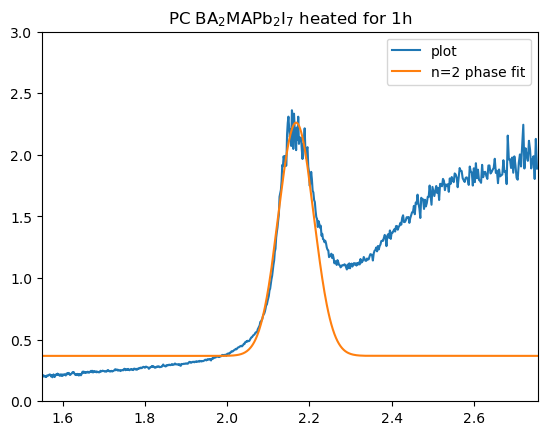

FWHM = 0.0504 ± 0.0008
x0 = 2.1677 ± 0.0006
A = 1.8934 ± 0.0141
y0 = 0.3685 ± 0.0066
Fit failed at 21


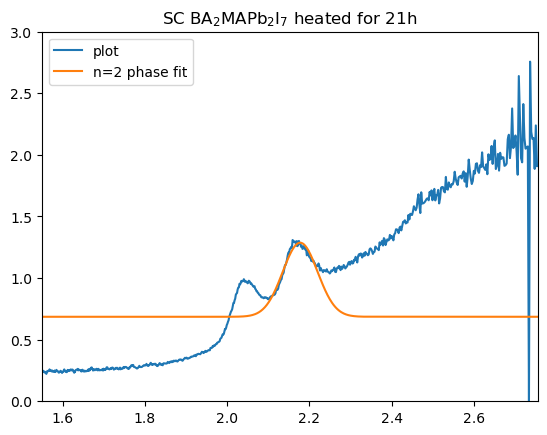

FWHM = 0.0499 ± 0.0035
x0 = 2.1776 ± 0.0007
A = 0.6013 ± 0.0457
y0 = 0.6859 ± 0.0484


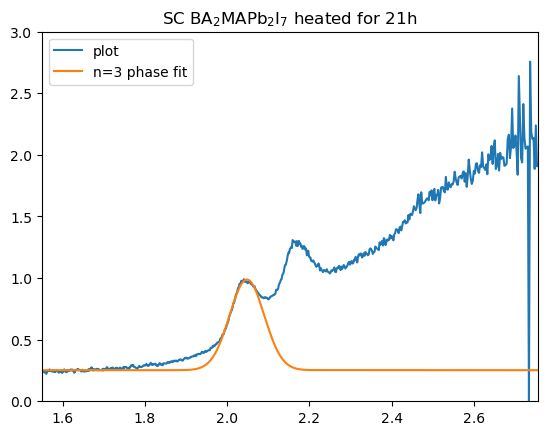

FWHM = 0.0496 ± 0.0025
x0 = 2.0482 ± 0.0004
A = 0.7355 ± 0.0454
y0 = 0.2525 ± 0.0470


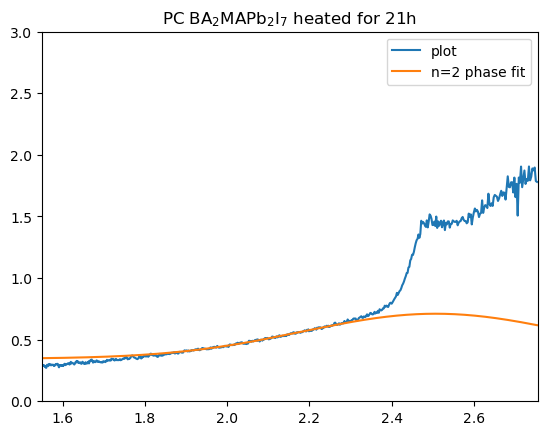

FWHM = 0.3787 ± 0.0908
x0 = 2.5068 ± 0.1410
A = 0.3650 ± 0.1071
y0 = 0.3456 ± 0.0211
Fit failed at 26


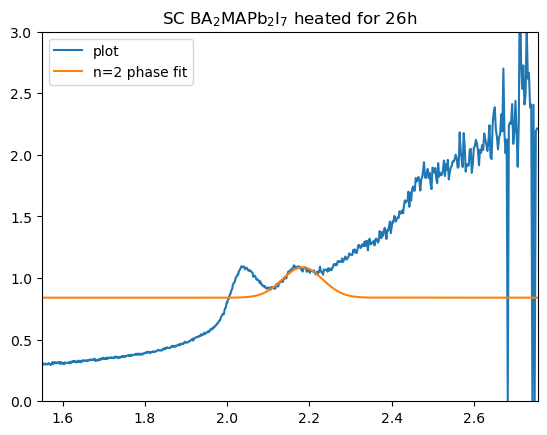

FWHM = 0.0572 ± 0.0059
x0 = 2.1833 ± 0.0011
A = 0.2469 ± 0.0283
y0 = 0.8408 ± 0.0298


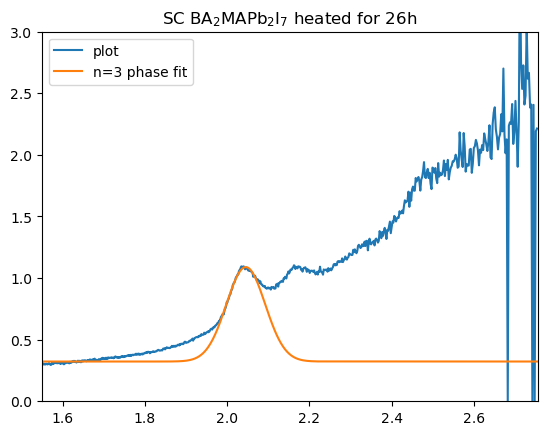

FWHM = 0.0555 ± 0.0038
x0 = 2.0454 ± 0.0003
A = 0.7667 ± 0.0743
y0 = 0.3227 ± 0.0758


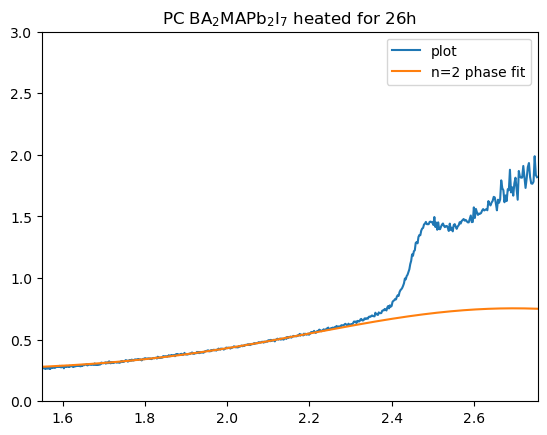

FWHM = 0.5740 ± 0.2253
x0 = 2.6966 ± 0.3191
A = 0.5062 ± 0.2310
y0 = 0.2484 ± 0.0593
Fit failed at 44


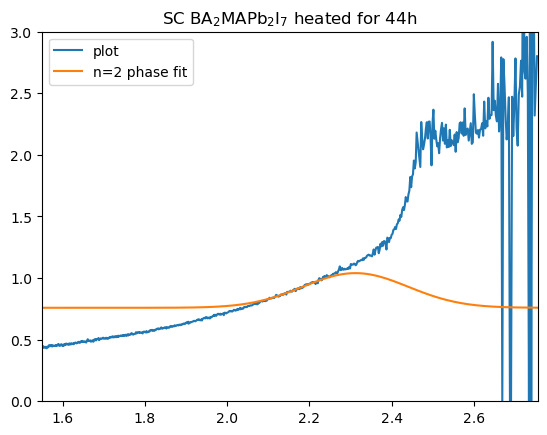

FWHM = 0.1509 ± 0.0717
x0 = 2.3119 ± 0.0778
A = 0.2813 ± 0.1270
y0 = 0.7589 ± 0.0571


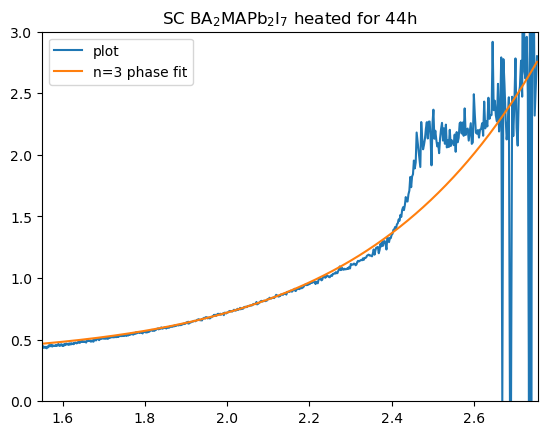

FWHM = 2.2846 ± 977.8175
x0 = 11.8305 ± 8071.8246
A = 135488.1697 ± 1371221871.0511
y0 = 0.3583 ± 12.6456


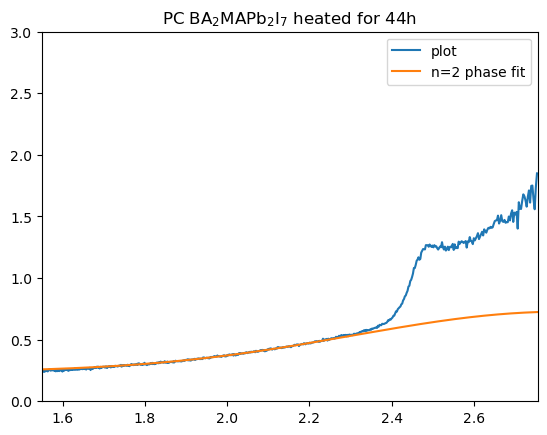

FWHM = 0.5960 ± 0.3377
x0 = 2.8131 ± 0.5924
A = 0.4903 ± 0.4010
y0 = 0.2372 ± 0.0543
Fit failed at 50


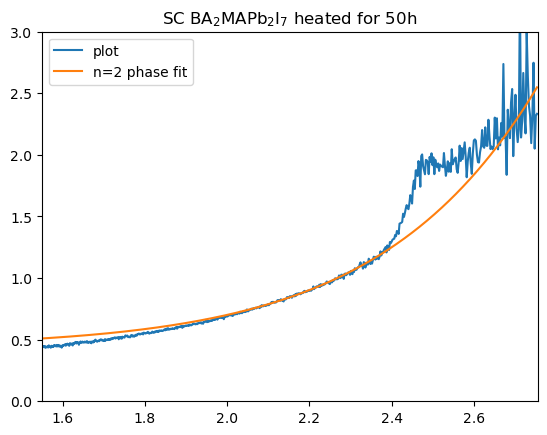

FWHM = 1.9474 ± 263.6607
x0 = 10.0058 ± 2032.8288
A = 31521.1217 ± 88039780.5601
y0 = 0.4434 ± 4.7683


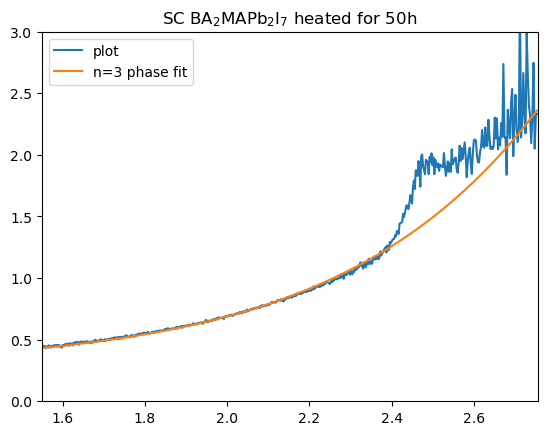

FWHM = 2.6112 ± 1603.0528
x0 = 13.1837 ± 13172.6556
A = 131467.7318 ± 1890649595.9486
y0 = 0.2938 ± 19.7717


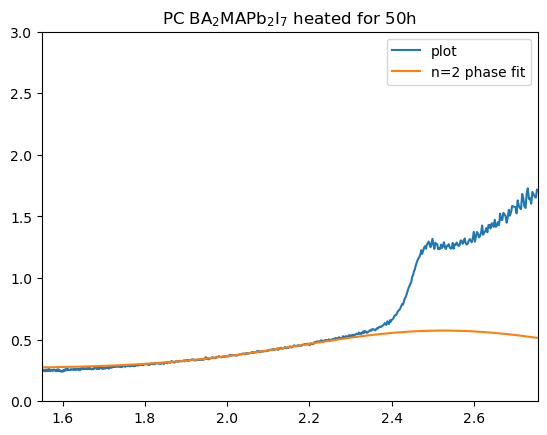

FWHM = 0.4092 ± 0.0928
x0 = 2.5256 ± 0.1362
A = 0.3049 ± 0.0808
y0 = 0.2691 ± 0.0187
Fit failed at 67


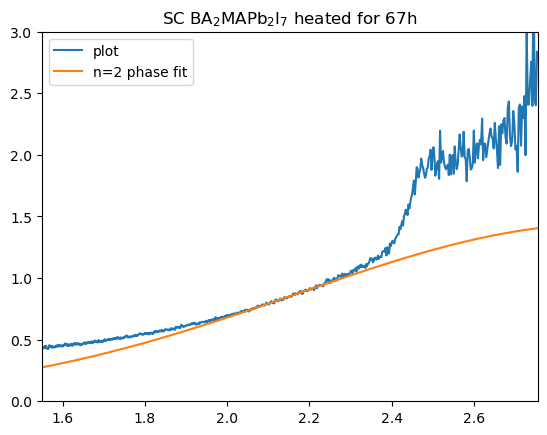

FWHM = 0.8894 ± 17.0089
x0 = 2.9281 ± 14.8185
A = 1.4398 ± 27.4694
y0 = 0.0025 ± 16.2434


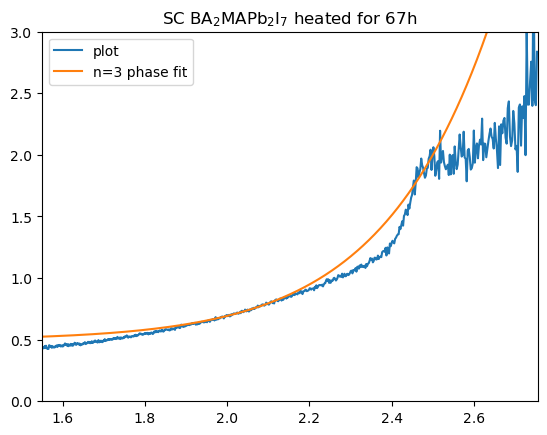

FWHM = 1.4499 ± 367.4162
x0 = 8.4358 ± 3129.8361
A = 166715.2592 ± 1063068612.0195
y0 = 0.4973 ± 4.0250


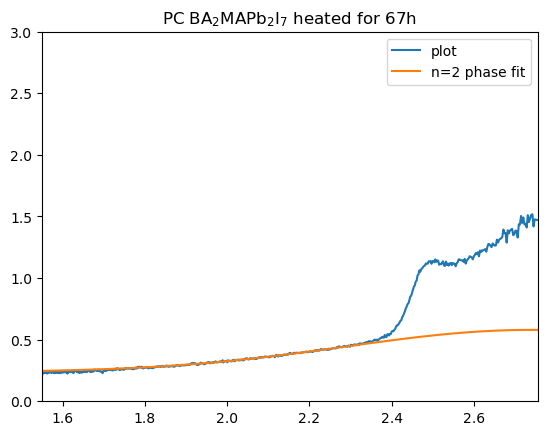

FWHM = 0.5290 ± 0.3224
x0 = 2.7386 ± 0.5781
A = 0.3428 ± 0.3082
y0 = 0.2368 ± 0.0384
Fit failed at 73


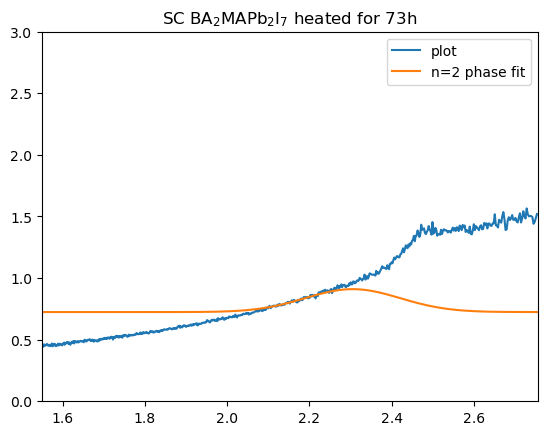

FWHM = 0.1361 ± 0.0907
x0 = 2.3052 ± 0.1080
A = 0.1860 ± 0.1205
y0 = 0.7242 ± 0.0458


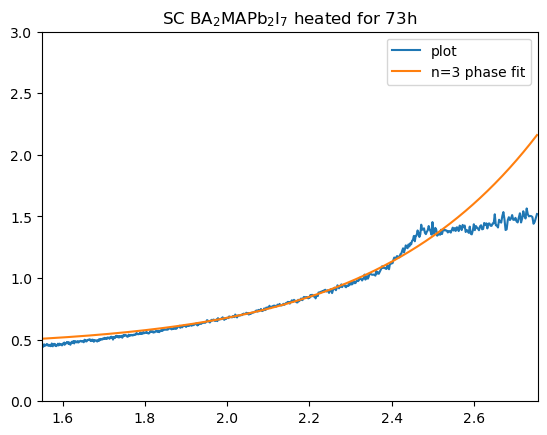

FWHM = 2.1990 ± 1522.1164
x0 = 11.5690 ± 12716.2083
A = 118482.7257 ± 1986890061.1841
y0 = 0.4410 ± 13.1399


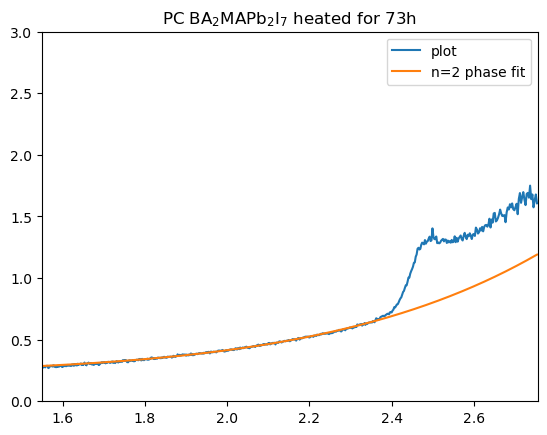

FWHM = 1.8190 ± 12.9866
x0 = 7.4625 ± 71.3738
A = 101.1659 ± 7618.4577
y0 = 0.2196 ± 0.2360
Fit failed at 139


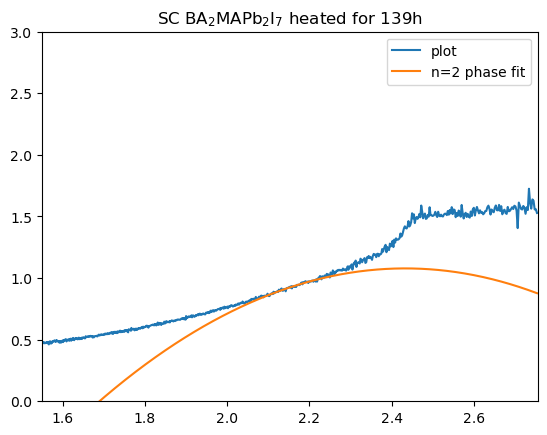

FWHM = 5.7536 ± 2599.1161
x0 = 2.4329 ± 0.7605
A = 93.7959 ± 84347.8855
y0 = -92.7174 ± 84347.5908


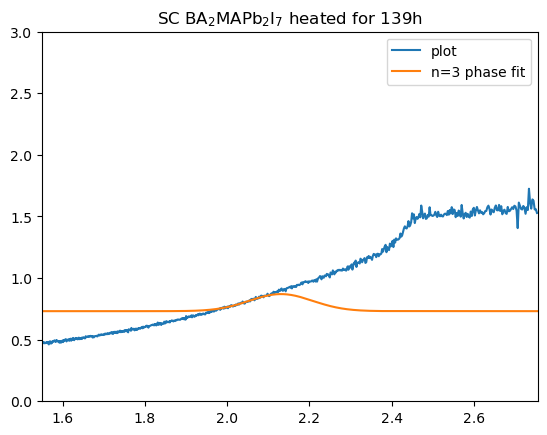

FWHM = 0.0907 ± 0.0533
x0 = 2.1309 ± 0.0694
A = 0.1386 ± 0.0825
y0 = 0.7315 ± 0.0258


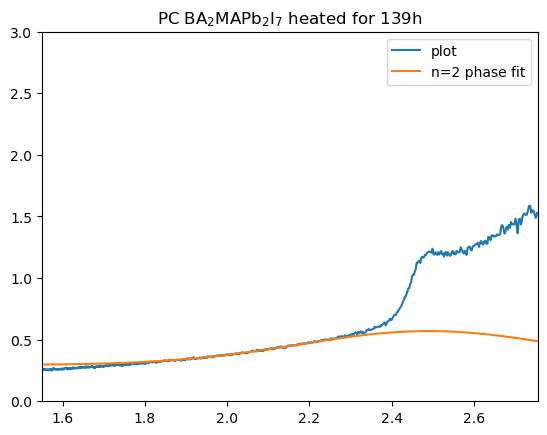

FWHM = 0.3703 ± 0.0784
x0 = 2.4901 ± 0.1185
A = 0.2749 ± 0.0691
y0 = 0.2949 ± 0.0147
Fit failed at 162


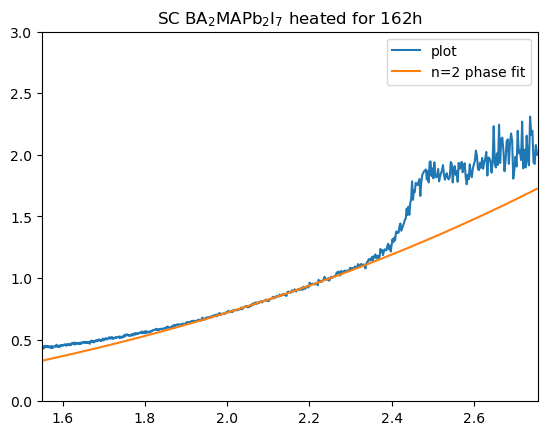

FWHM = 3.4861 ± 1662.8532
x0 = 9.4786 ± 5996.1388
A = 29.0378 ± 64605.6665
y0 = -0.4758 ± 184.1540


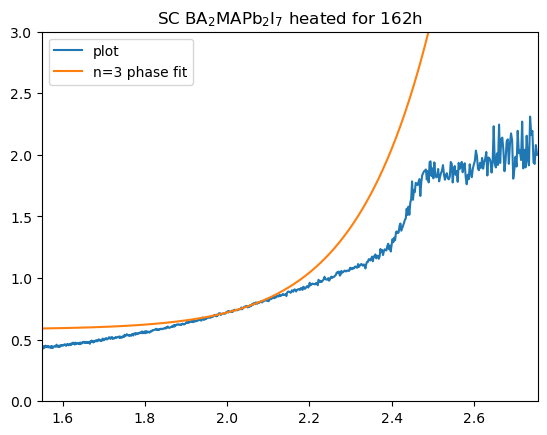

FWHM = 0.9980 ± 96.5875
x0 = 6.4590 ± 826.4686
A = 139695.7769 ± 343132361.9227
y0 = 0.5837 ± 1.1361


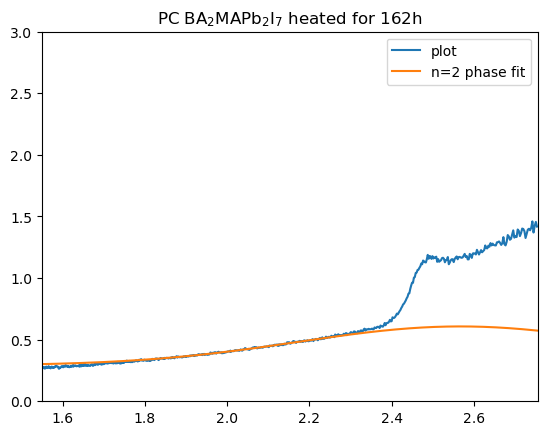

FWHM = 0.4625 ± 0.1758
x0 = 2.5670 ± 0.2434
A = 0.3169 ± 0.1356
y0 = 0.2906 ± 0.0367
Fit failed at 167


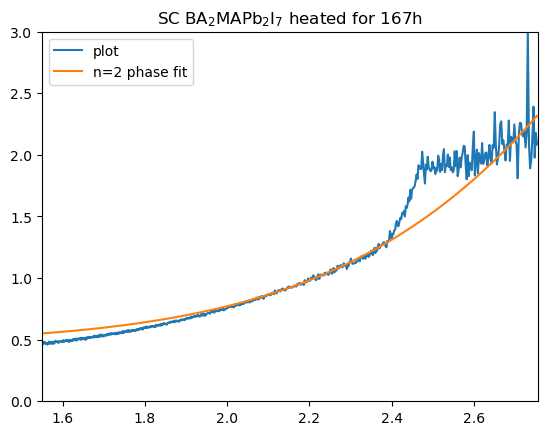

FWHM = 1.2212 ± 83.1875
x0 = 4.9766 ± 337.2468
A = 18.3552 ± 7282.0799
y0 = 0.4725 ± 7.5561


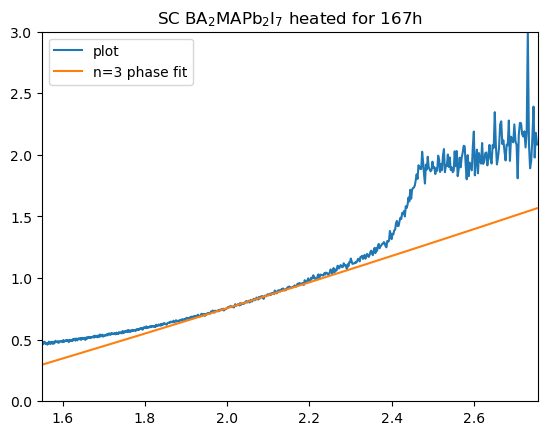

FWHM = 47.1361 ± 33763.0054
x0 = 157.8236 ± 208615.0347
A = 20860.0112 ± 198698512.9433
y0 = -9.9477 ± 1038.4817


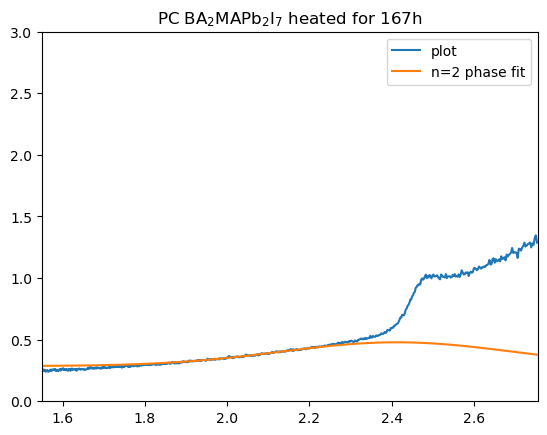

FWHM = 0.3314 ± 0.0711
x0 = 2.4124 ± 0.0923
A = 0.1931 ± 0.0426
y0 = 0.2857 ± 0.0134
Fit failed at 185


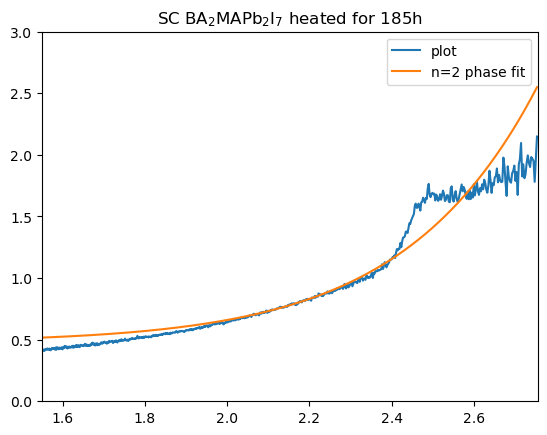

FWHM = 2.0869 ± 366.7799
x0 = 12.5252 ± 3538.1003
A = 8253831.3411 ± 46780858564.4349
y0 = 0.4778 ± 3.1300


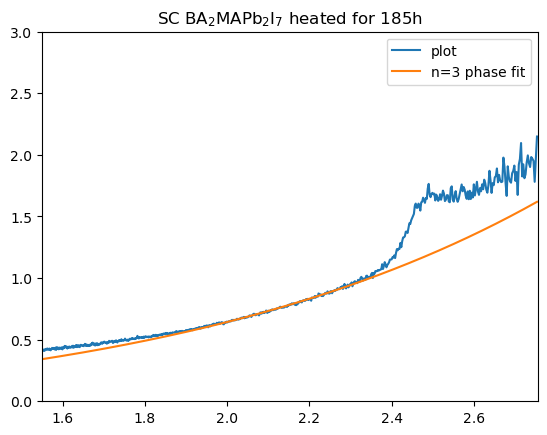

FWHM = 5.1583 ± 13138.4182
x0 = 23.4827 ± 104906.8820
A = 125912.2884 ± 7099635961.1801
y0 = -0.1132 ± 159.5154


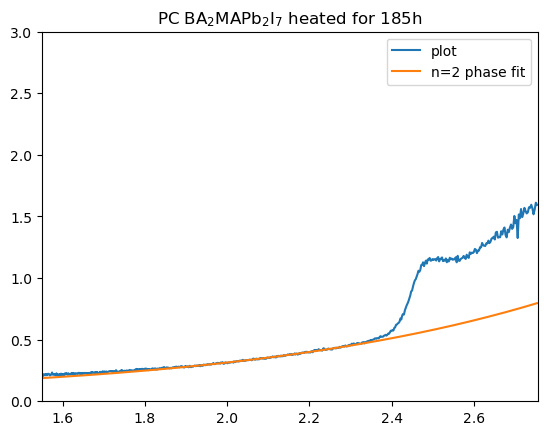

FWHM = 4.4676 ± 211.8251
x0 = 21.9702 ± 1822.4752
A = 278911.5853 ± 339506713.7256
y0 = 0.0448 ± 0.9598
Fit failed at 192


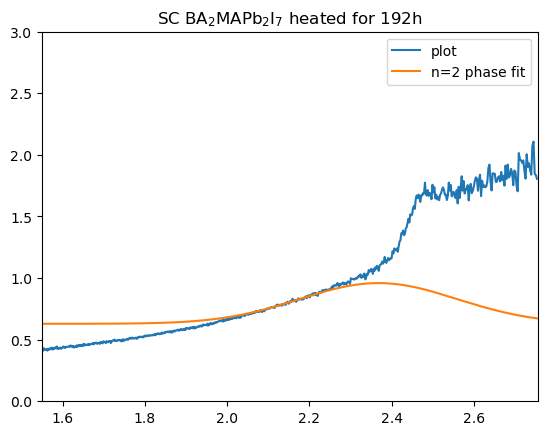

FWHM = 0.2257 ± 0.3116
x0 = 2.3679 ± 0.2965
A = 0.3303 ± 0.4408
y0 = 0.6291 ± 0.2378


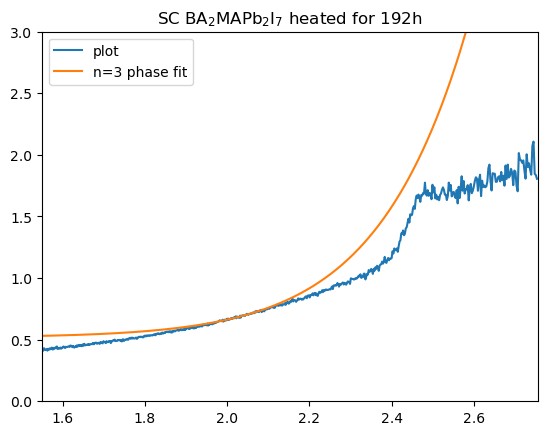

FWHM = 1.2094 ± 191.6102
x0 = 7.4611 ± 1660.7855
A = 198230.0709 ± 817925299.0877
y0 = 0.5183 ± 1.8543


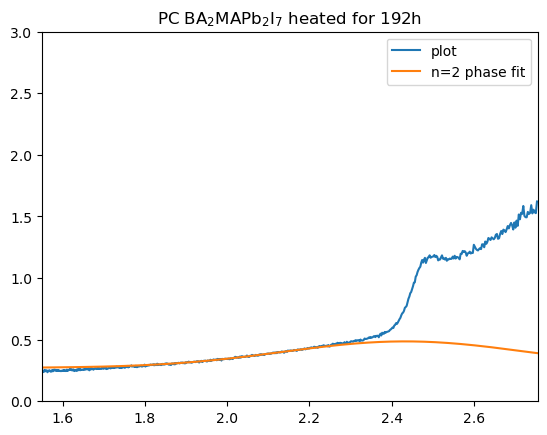

FWHM = 0.3487 ± 0.0655
x0 = 2.4327 ± 0.0860
A = 0.2145 ± 0.0421
y0 = 0.2716 ± 0.0129
Fit failed at 209


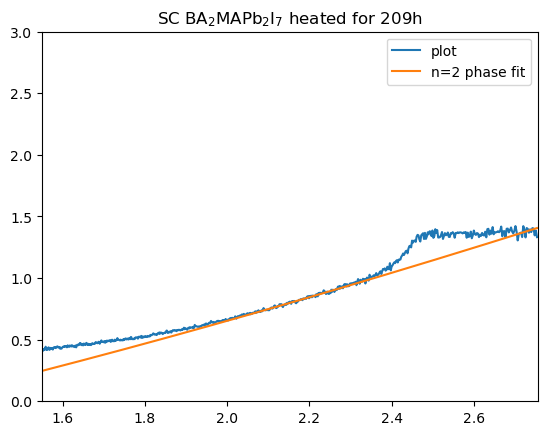

FWHM = 4.9090 ± 4111.2913
x0 = 7.9951 ± 6463.2914
A = 7.6830 ± 8422.2617
y0 = -2.0796 ± 1636.5609
Fit failed at 209


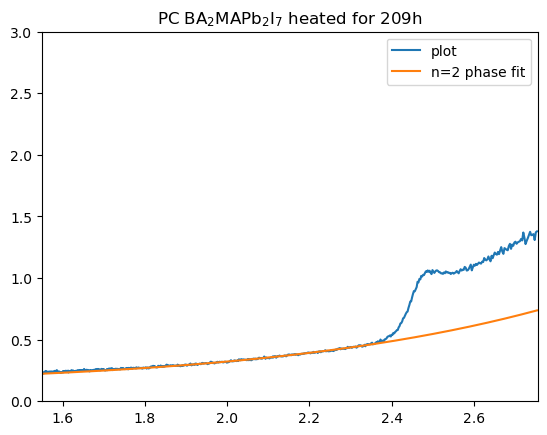

FWHM = 2.9724 ± 86.7769
x0 = 12.2057 ± 558.2019
A = 669.4251 ± 281210.1366
y0 = 0.1331 ± 0.6971
Fit failed at 215


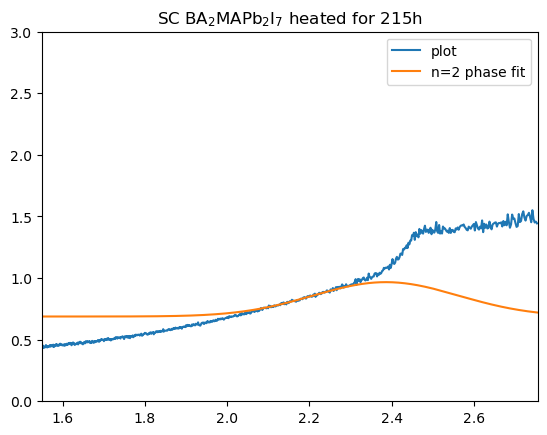

FWHM = 0.2088 ± 0.2644
x0 = 2.3858 ± 0.3379
A = 0.2790 ± 0.3782
y0 = 0.6881 ± 0.1236


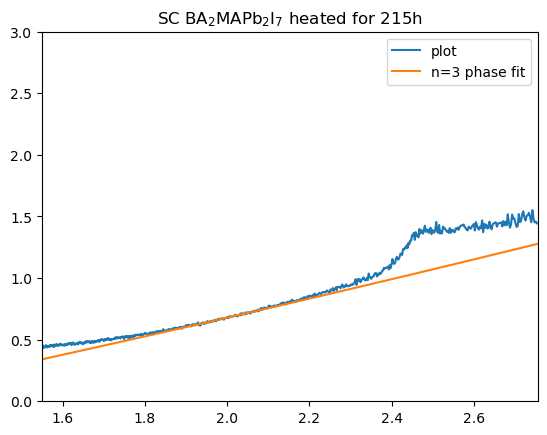

FWHM = 46.5501 ± 41408.9954
x0 = 157.8099 ± 260230.3984
A = 18139.7150 ± 221981260.3046
y0 = -7.0142 ± 864.2427


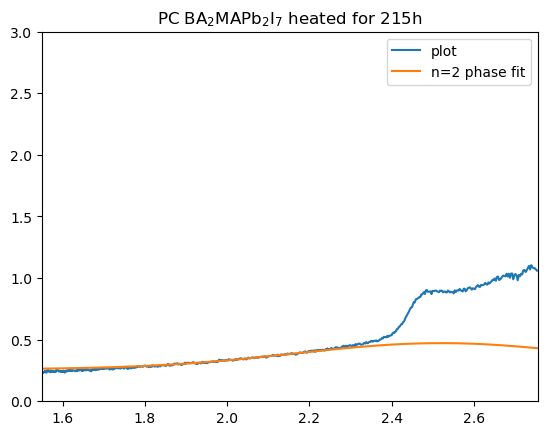

FWHM = 0.4174 ± 0.1643
x0 = 2.5206 ± 0.2293
A = 0.2120 ± 0.0936
y0 = 0.2600 ± 0.0248
Optimisation parameters stored


In [190]:
ba2pbi4_parameters1, sc_n2_parameters1, sc_n3_parameters1, pc_parameters1 = InNominePatrisEtFiliiEtSpiritusSancti(data_dict1,
                                                                                                              q1min=2,
                                                                                                              q1max=2.45,
                                                                                                              q2min=2.1,
                                                                                                              q2max=2.225,
                                                                                                              q3min=1.985,
                                                                                                              q3max=2.075,
                                                                                                              q4min=1.9,
                                                                                                              q4max=2.2,
                                                                                                                GraphOn=True,
                                                                                                                ParamsOn=True)

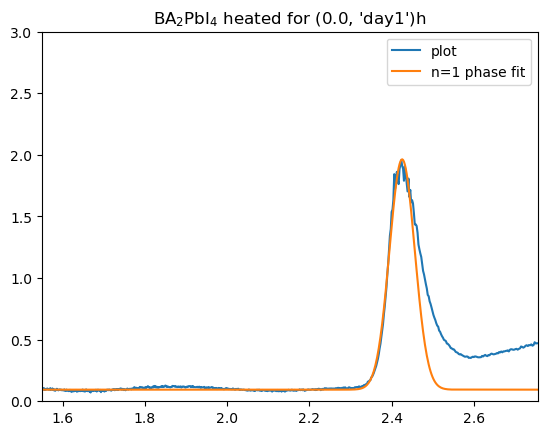

FWHM = 0.0361 ± 0.0003
x0 = 2.4254 ± 0.0003
A = 1.8697 ± 0.0083
y0 = 0.0943 ± 0.0023


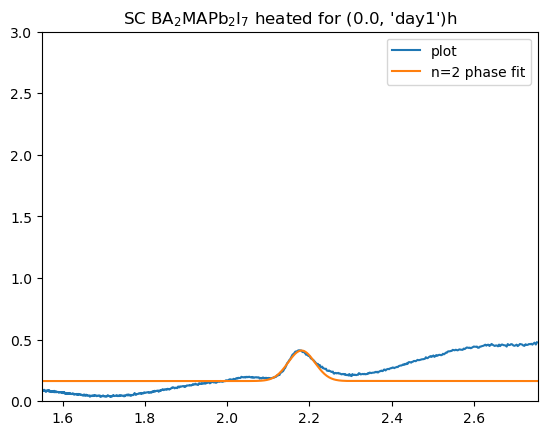

FWHM = 0.0384 ± 0.0010
x0 = 2.1809 ± 0.0004
A = 0.2475 ± 0.0052
y0 = 0.1643 ± 0.0055


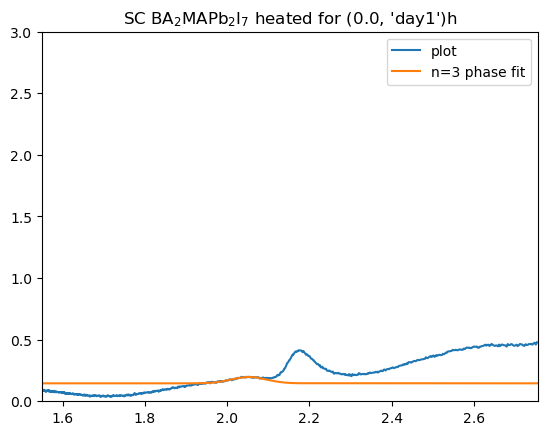

FWHM = 0.0498 ± 0.0065
x0 = 2.0534 ± 0.0014
A = 0.0513 ± 0.0072
y0 = 0.1457 ± 0.0075


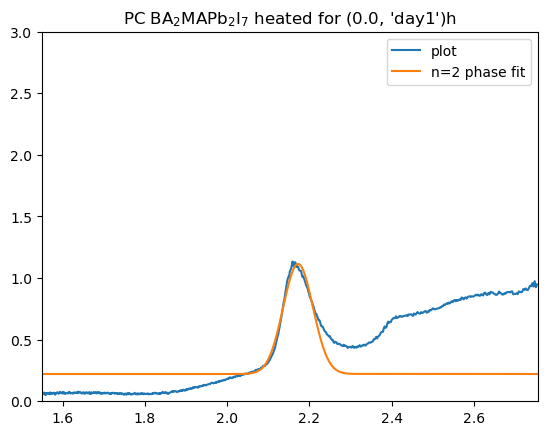

FWHM = 0.0426 ± 0.0008
x0 = 2.1725 ± 0.0004
A = 0.8934 ± 0.0112
y0 = 0.2214 ± 0.0094


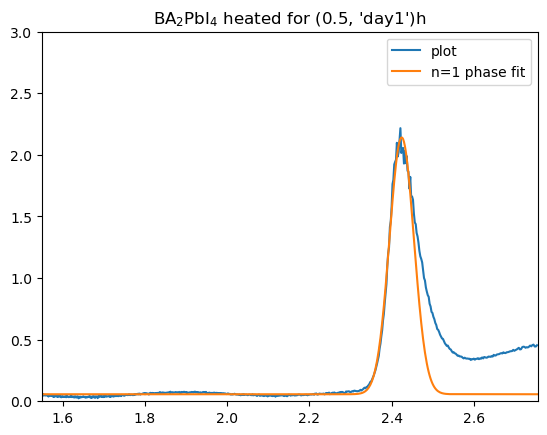

FWHM = 0.0349 ± 0.0003
x0 = 2.4243 ± 0.0002
A = 2.0847 ± 0.0086
y0 = 0.0571 ± 0.0023


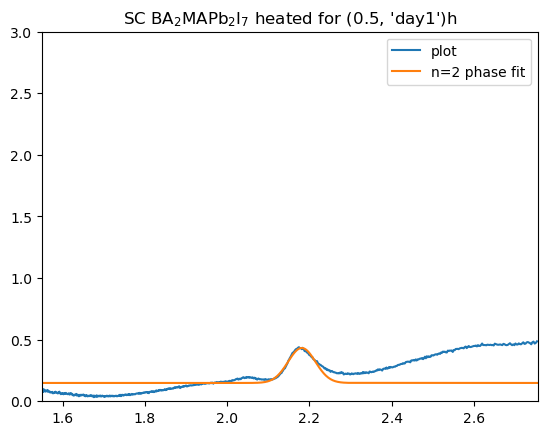

FWHM = 0.0391 ± 0.0011
x0 = 2.1815 ± 0.0004
A = 0.2840 ± 0.0062
y0 = 0.1487 ± 0.0066


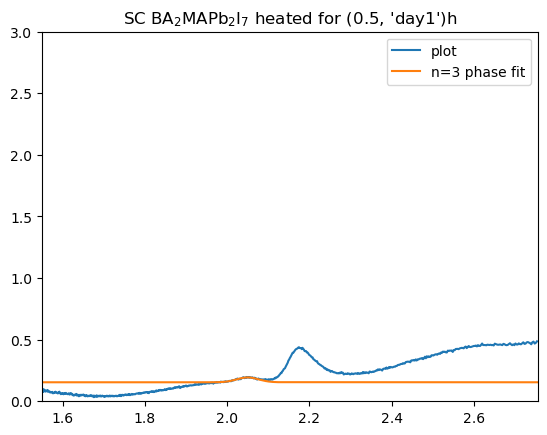

FWHM = 0.0309 ± 0.0018
x0 = 2.0504 ± 0.0007
A = 0.0394 ± 0.0016
y0 = 0.1543 ± 0.0017


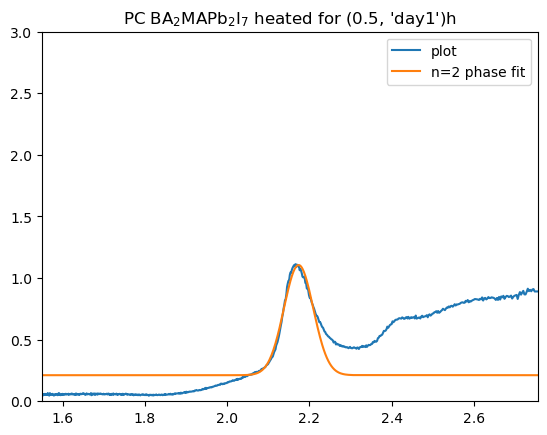

FWHM = 0.0420 ± 0.0007
x0 = 2.1738 ± 0.0004
A = 0.8942 ± 0.0099
y0 = 0.2117 ± 0.0081


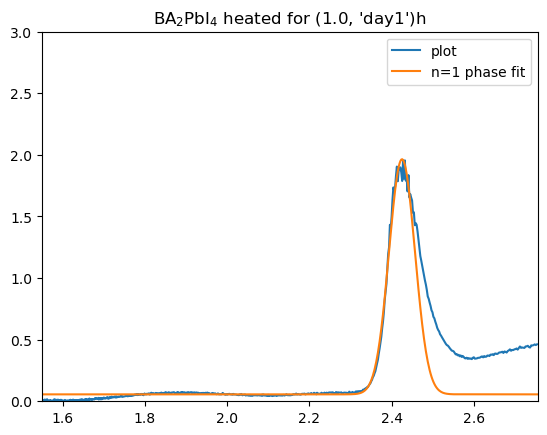

FWHM = 0.0371 ± 0.0003
x0 = 2.4251 ± 0.0003
A = 1.9088 ± 0.0086
y0 = 0.0562 ± 0.0024


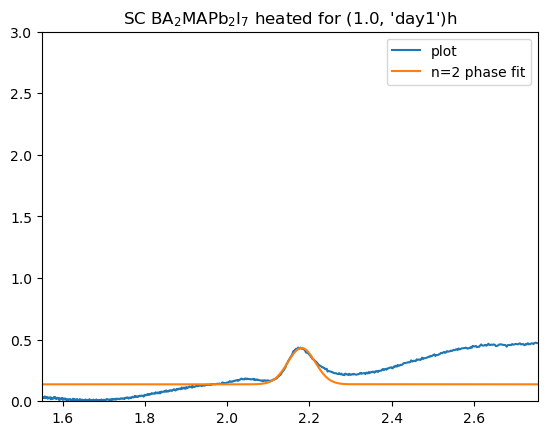

FWHM = 0.0393 ± 0.0010
x0 = 2.1810 ± 0.0003
A = 0.2951 ± 0.0059
y0 = 0.1377 ± 0.0063


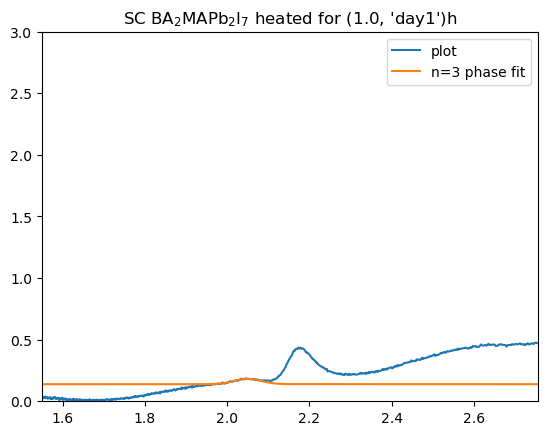

FWHM = 0.0390 ± 0.0035
x0 = 2.0504 ± 0.0010
A = 0.0434 ± 0.0035
y0 = 0.1386 ± 0.0038


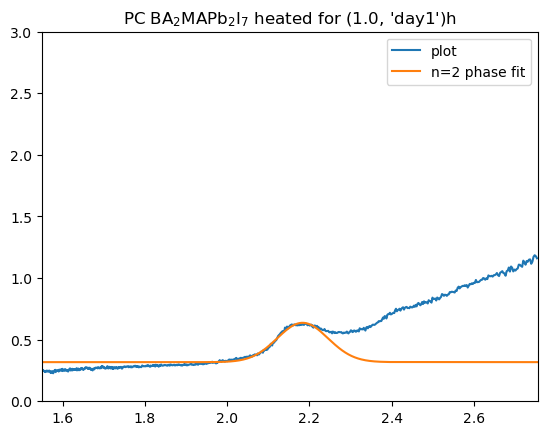

FWHM = 0.0727 ± 0.0023
x0 = 2.1835 ± 0.0009
A = 0.3193 ± 0.0074
y0 = 0.3177 ± 0.0080


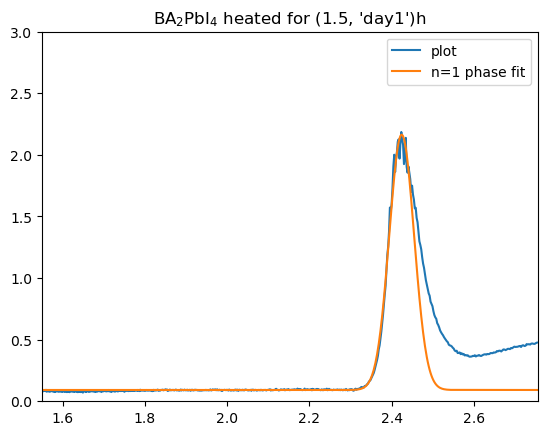

FWHM = 0.0355 ± 0.0003
x0 = 2.4243 ± 0.0002
A = 2.0728 ± 0.0093
y0 = 0.0917 ± 0.0025


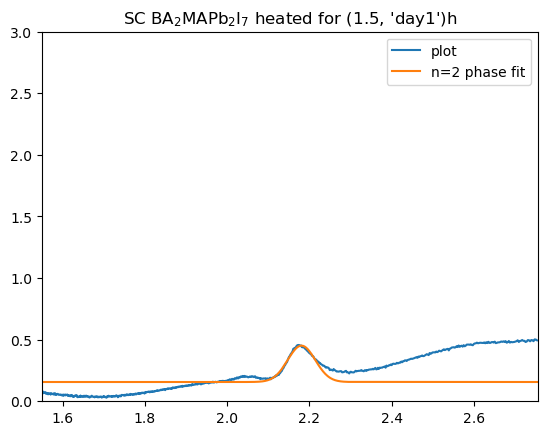

FWHM = 0.0393 ± 0.0011
x0 = 2.1808 ± 0.0004
A = 0.2953 ± 0.0066
y0 = 0.1565 ± 0.0070


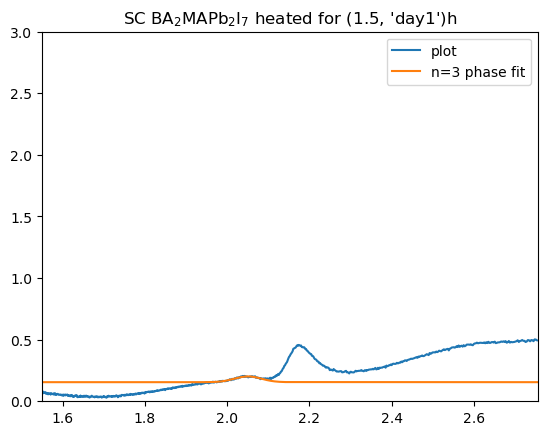

FWHM = 0.0381 ± 0.0036
x0 = 2.0509 ± 0.0011
A = 0.0468 ± 0.0038
y0 = 0.1551 ± 0.0041


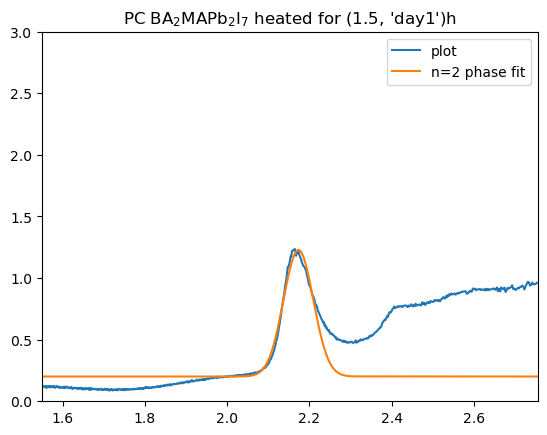

FWHM = 0.0426 ± 0.0008
x0 = 2.1734 ± 0.0004
A = 1.0268 ± 0.0128
y0 = 0.2011 ± 0.0107


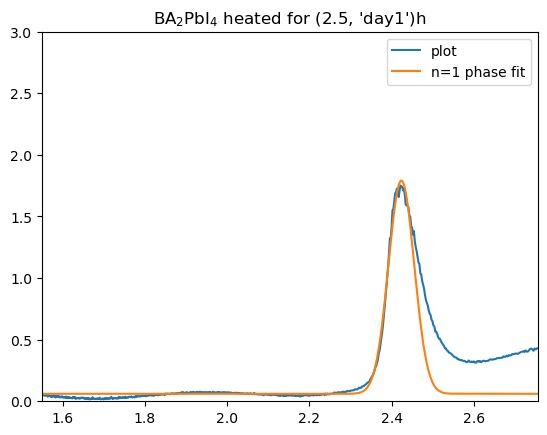

FWHM = 0.0368 ± 0.0003
x0 = 2.4236 ± 0.0002
A = 1.7306 ± 0.0074
y0 = 0.0608 ± 0.0020


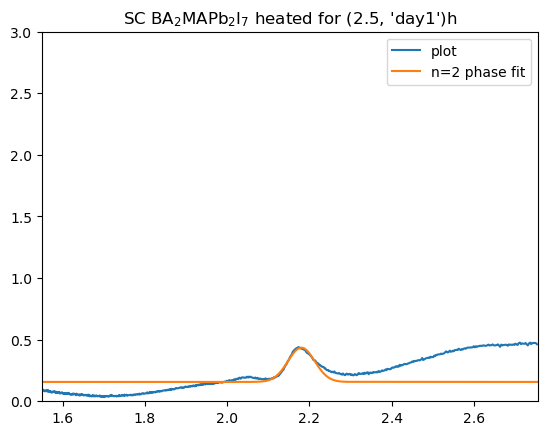

FWHM = 0.0383 ± 0.0010
x0 = 2.1805 ± 0.0004
A = 0.2781 ± 0.0057
y0 = 0.1571 ± 0.0061


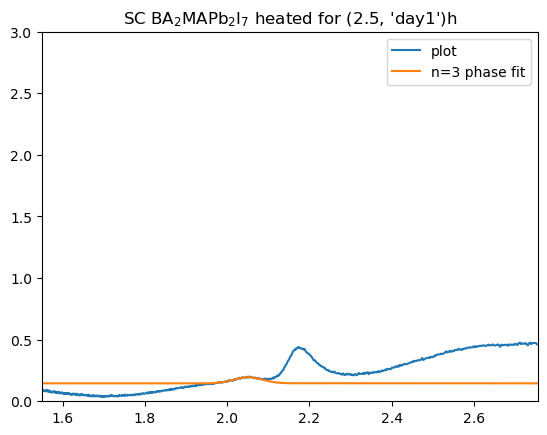

FWHM = 0.0403 ± 0.0036
x0 = 2.0517 ± 0.0010
A = 0.0497 ± 0.0039
y0 = 0.1456 ± 0.0041


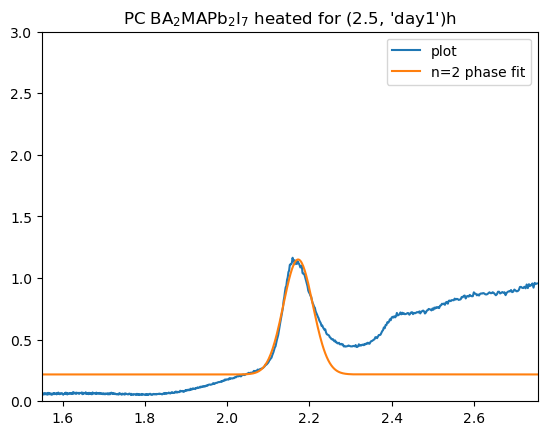

FWHM = 0.0421 ± 0.0007
x0 = 2.1726 ± 0.0004
A = 0.9331 ± 0.0116
y0 = 0.2178 ± 0.0096


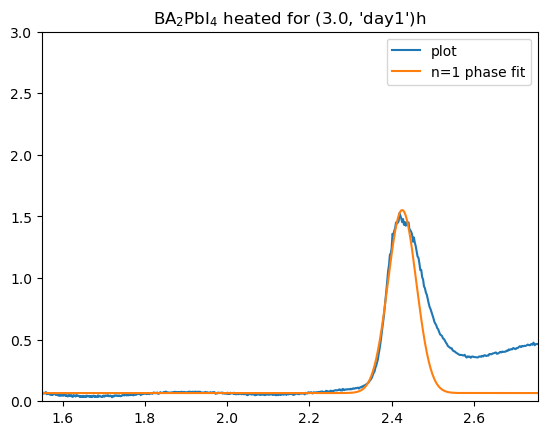

FWHM = 0.0406 ± 0.0004
x0 = 2.4255 ± 0.0003
A = 1.4856 ± 0.0072
y0 = 0.0668 ± 0.0021


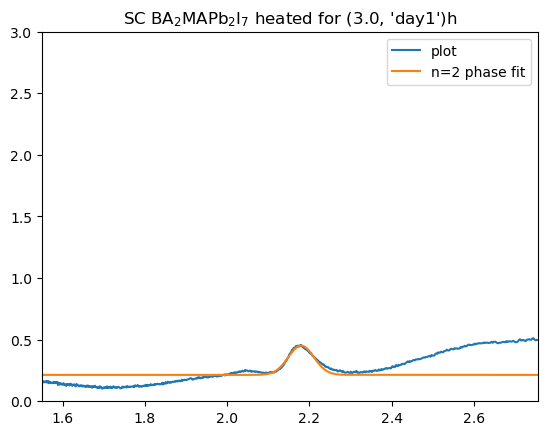

FWHM = 0.0365 ± 0.0010
x0 = 2.1798 ± 0.0004
A = 0.2377 ± 0.0048
y0 = 0.2141 ± 0.0051


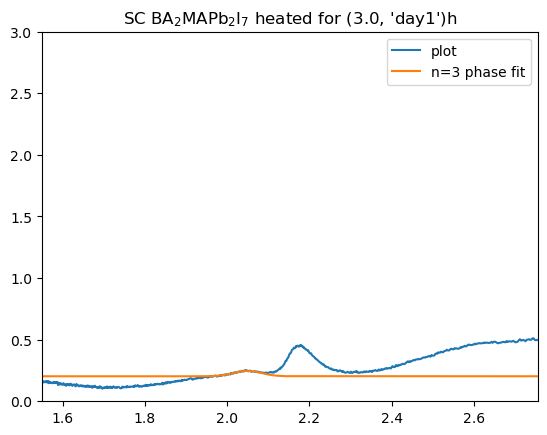

FWHM = 0.0393 ± 0.0035
x0 = 2.0500 ± 0.0010
A = 0.0439 ± 0.0036
y0 = 0.2030 ± 0.0038


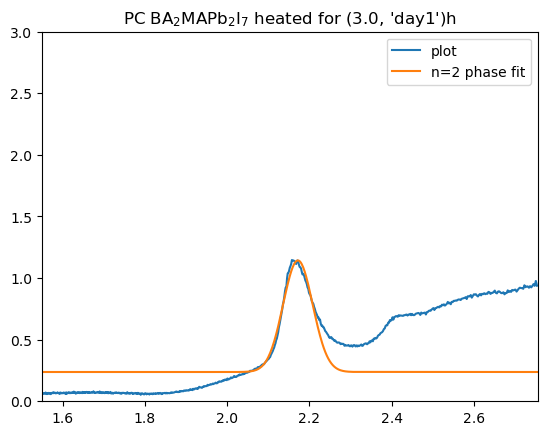

FWHM = 0.0422 ± 0.0007
x0 = 2.1721 ± 0.0004
A = 0.9055 ± 0.0110
y0 = 0.2377 ± 0.0092


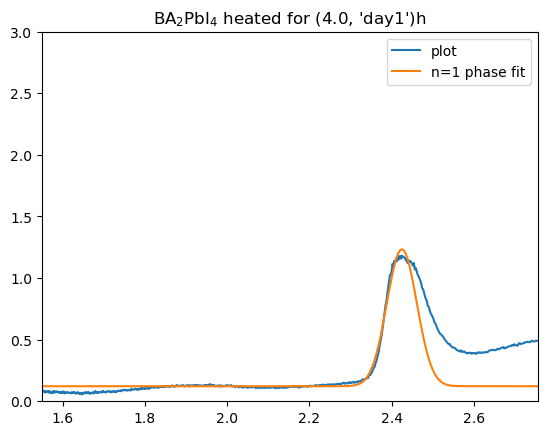

FWHM = 0.0429 ± 0.0005
x0 = 2.4248 ± 0.0004
A = 1.1106 ± 0.0061
y0 = 0.1222 ± 0.0018


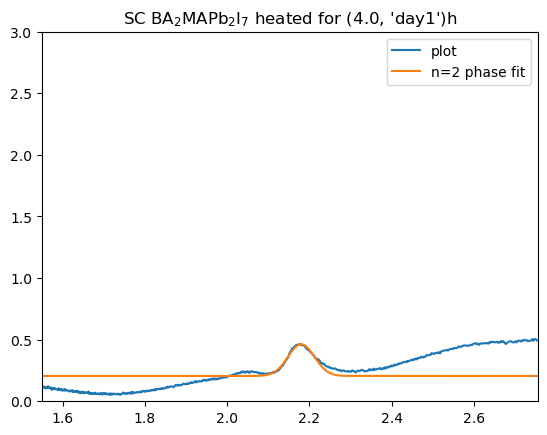

FWHM = 0.0376 ± 0.0010
x0 = 2.1801 ± 0.0004
A = 0.2578 ± 0.0052
y0 = 0.2054 ± 0.0055


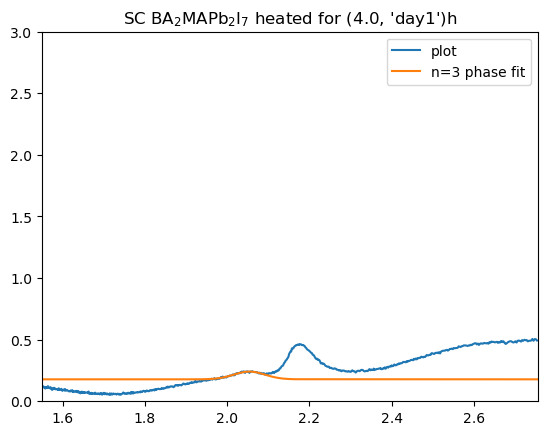

FWHM = 0.0446 ± 0.0044
x0 = 2.0541 ± 0.0013
A = 0.0627 ± 0.0057
y0 = 0.1782 ± 0.0060


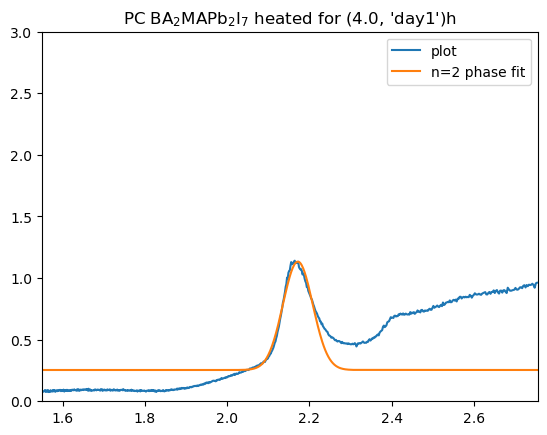

FWHM = 0.0426 ± 0.0007
x0 = 2.1720 ± 0.0004
A = 0.8795 ± 0.0106
y0 = 0.2539 ± 0.0089


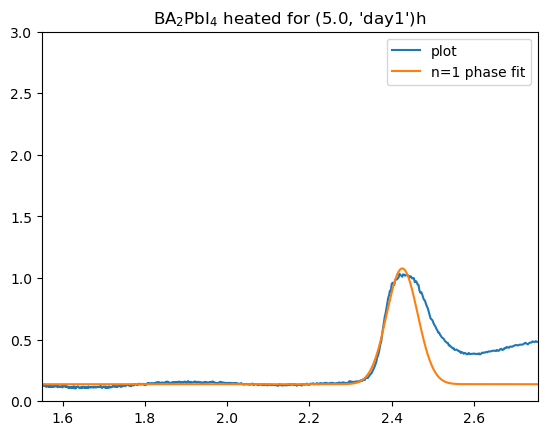

FWHM = 0.0442 ± 0.0005
x0 = 2.4256 ± 0.0005
A = 0.9399 ± 0.0052
y0 = 0.1386 ± 0.0016


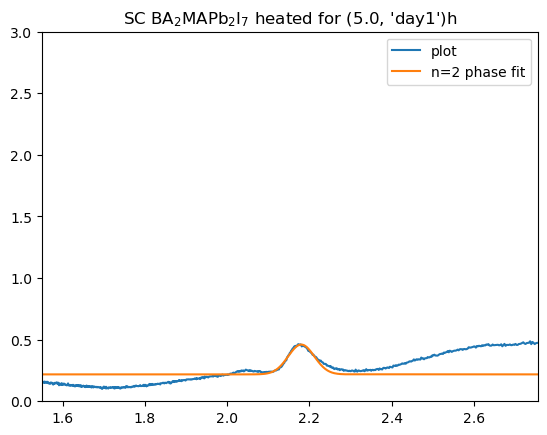

FWHM = 0.0372 ± 0.0009
x0 = 2.1802 ± 0.0003
A = 0.2422 ± 0.0047
y0 = 0.2183 ± 0.0050


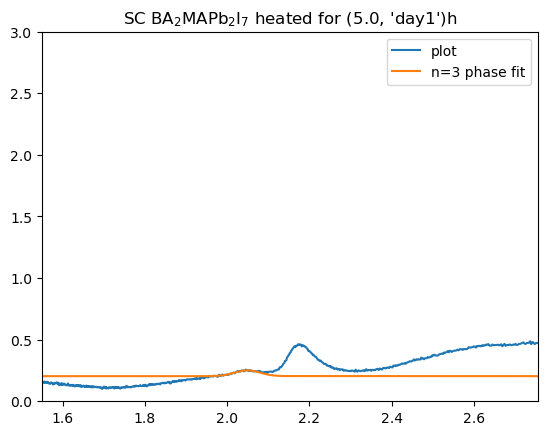

FWHM = 0.0363 ± 0.0028
x0 = 2.0495 ± 0.0008
A = 0.0470 ± 0.0030
y0 = 0.2040 ± 0.0032


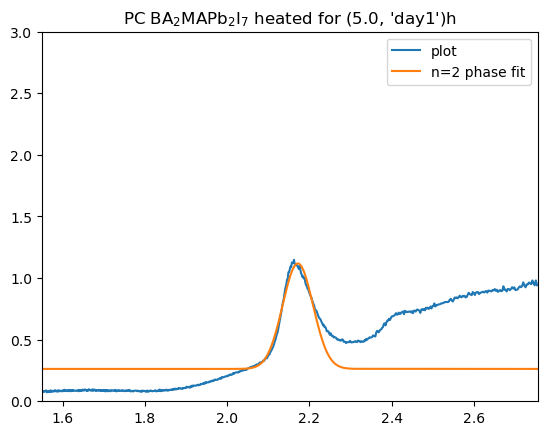

FWHM = 0.0434 ± 0.0008
x0 = 2.1720 ± 0.0004
A = 0.8559 ± 0.0110
y0 = 0.2628 ± 0.0095


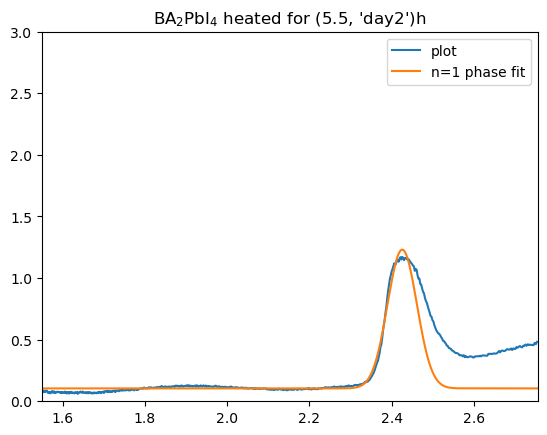

FWHM = 0.0420 ± 0.0005
x0 = 2.4256 ± 0.0004
A = 1.1265 ± 0.0062
y0 = 0.1045 ± 0.0018


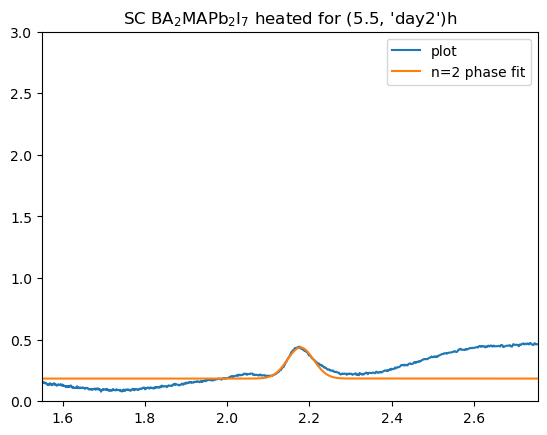

FWHM = 0.0375 ± 0.0010
x0 = 2.1784 ± 0.0004
A = 0.2520 ± 0.0056
y0 = 0.1843 ± 0.0060


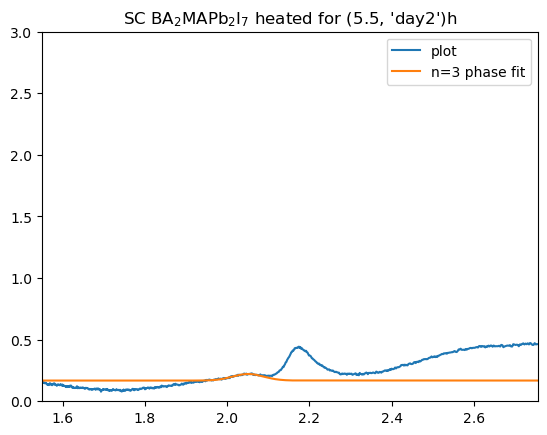

FWHM = 0.0442 ± 0.0051
x0 = 2.0514 ± 0.0012
A = 0.0532 ± 0.0061
y0 = 0.1683 ± 0.0064


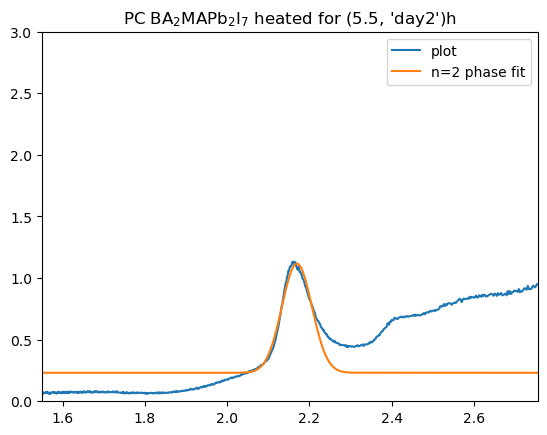

FWHM = 0.0430 ± 0.0008
x0 = 2.1697 ± 0.0004
A = 0.8857 ± 0.0114
y0 = 0.2314 ± 0.0099


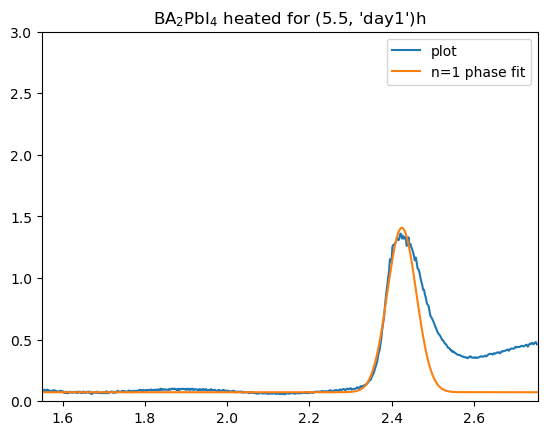

FWHM = 0.0414 ± 0.0004
x0 = 2.4247 ± 0.0004
A = 1.3348 ± 0.0069
y0 = 0.0734 ± 0.0020


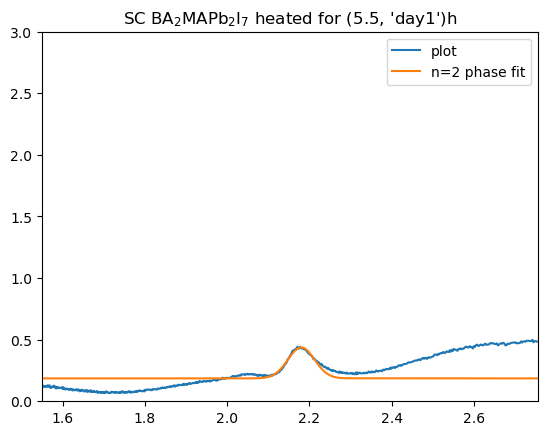

FWHM = 0.0381 ± 0.0010
x0 = 2.1802 ± 0.0003
A = 0.2514 ± 0.0051
y0 = 0.1859 ± 0.0054


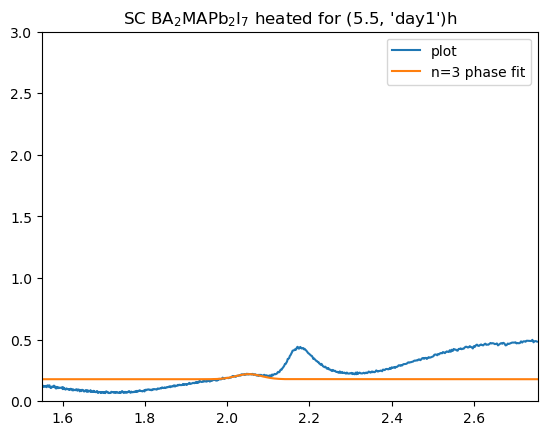

FWHM = 0.0368 ± 0.0029
x0 = 2.0527 ± 0.0011
A = 0.0413 ± 0.0025
y0 = 0.1791 ± 0.0027


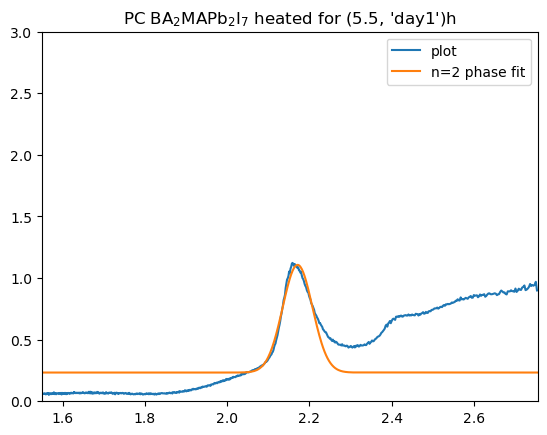

FWHM = 0.0426 ± 0.0008
x0 = 2.1713 ± 0.0004
A = 0.8739 ± 0.0112
y0 = 0.2333 ± 0.0095


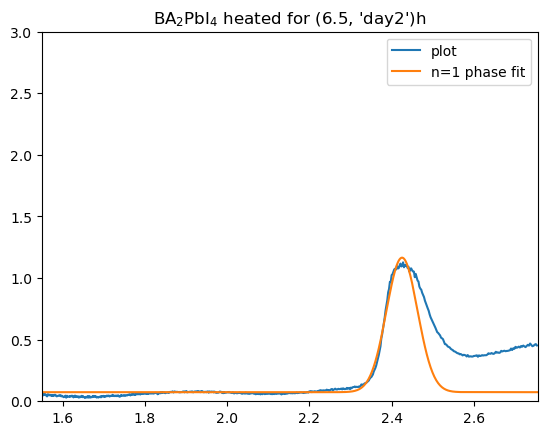

FWHM = 0.0445 ± 0.0005
x0 = 2.4252 ± 0.0005
A = 1.0920 ± 0.0061
y0 = 0.0739 ± 0.0019


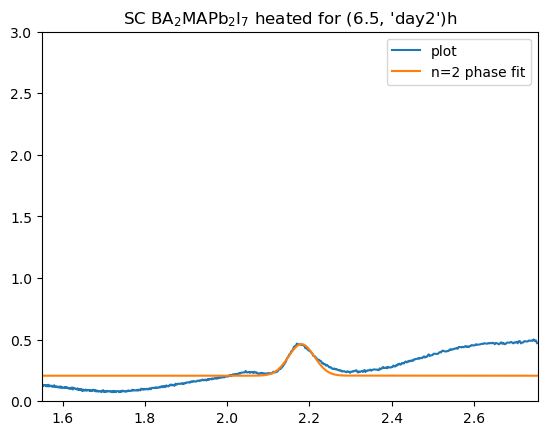

FWHM = 0.0371 ± 0.0009
x0 = 2.1807 ± 0.0004
A = 0.2556 ± 0.0050
y0 = 0.2075 ± 0.0052


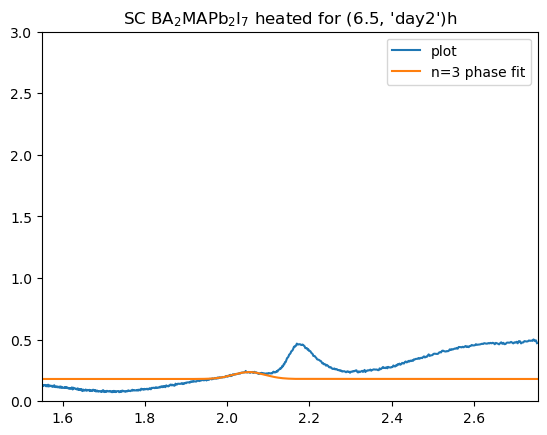

FWHM = 0.0456 ± 0.0047
x0 = 2.0537 ± 0.0012
A = 0.0560 ± 0.0055
y0 = 0.1810 ± 0.0058


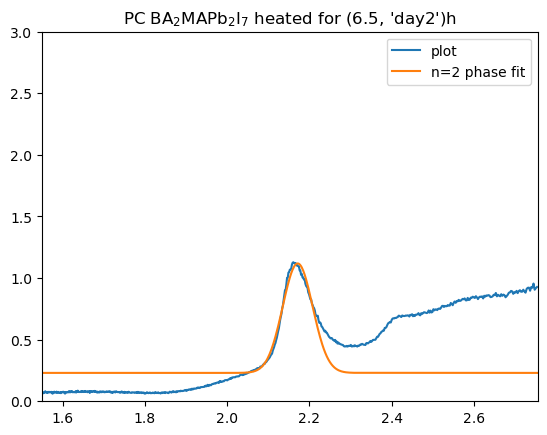

FWHM = 0.0428 ± 0.0008
x0 = 2.1716 ± 0.0004
A = 0.8883 ± 0.0111
y0 = 0.2303 ± 0.0094


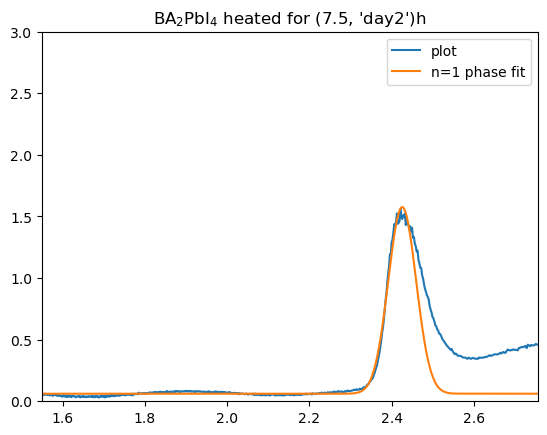

FWHM = 0.0398 ± 0.0004
x0 = 2.4256 ± 0.0003
A = 1.5152 ± 0.0073
y0 = 0.0614 ± 0.0021


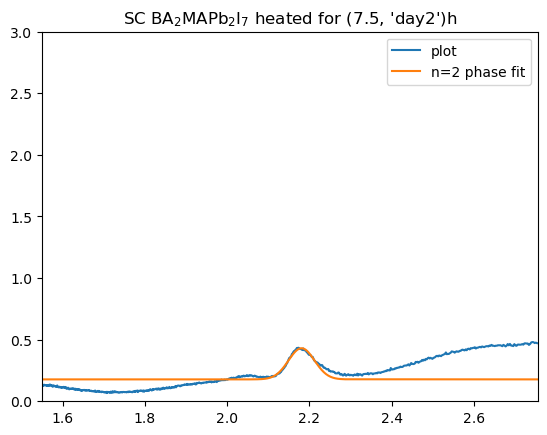

FWHM = 0.0373 ± 0.0009
x0 = 2.1809 ± 0.0004
A = 0.2530 ± 0.0049
y0 = 0.1777 ± 0.0052


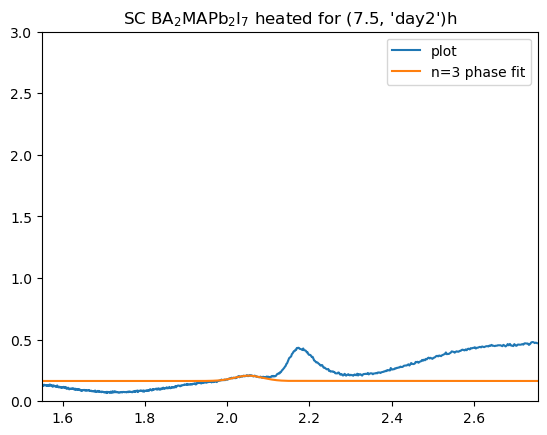

FWHM = 0.0407 ± 0.0039
x0 = 2.0527 ± 0.0012
A = 0.0430 ± 0.0036
y0 = 0.1648 ± 0.0039


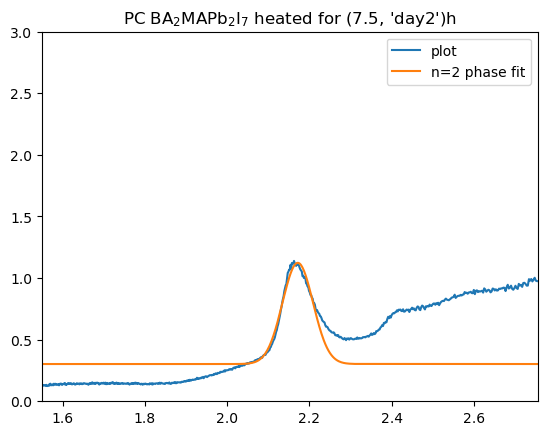

FWHM = 0.0437 ± 0.0008
x0 = 2.1718 ± 0.0004
A = 0.8214 ± 0.0101
y0 = 0.3024 ± 0.0088


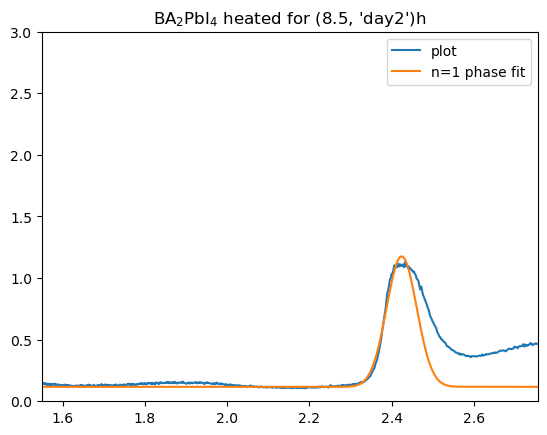

FWHM = 0.0431 ± 0.0005
x0 = 2.4242 ± 0.0004
A = 1.0588 ± 0.0059
y0 = 0.1174 ± 0.0018


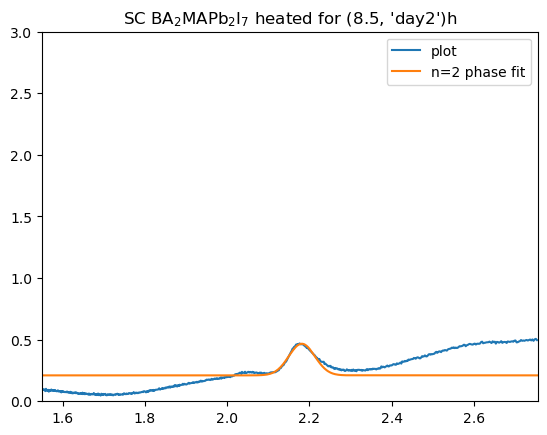

FWHM = 0.0372 ± 0.0009
x0 = 2.1816 ± 0.0003
A = 0.2568 ± 0.0045
y0 = 0.2103 ± 0.0047


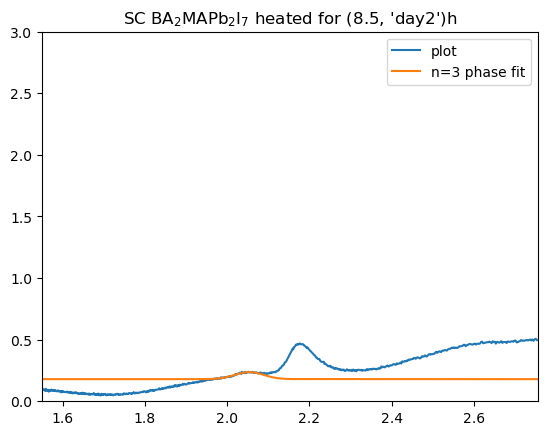

FWHM = 0.0409 ± 0.0035
x0 = 2.0540 ± 0.0012
A = 0.0572 ± 0.0041
y0 = 0.1796 ± 0.0044


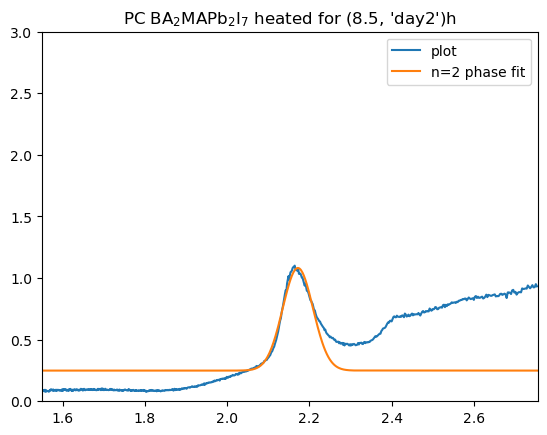

FWHM = 0.0434 ± 0.0007
x0 = 2.1720 ± 0.0004
A = 0.8329 ± 0.0100
y0 = 0.2491 ± 0.0086


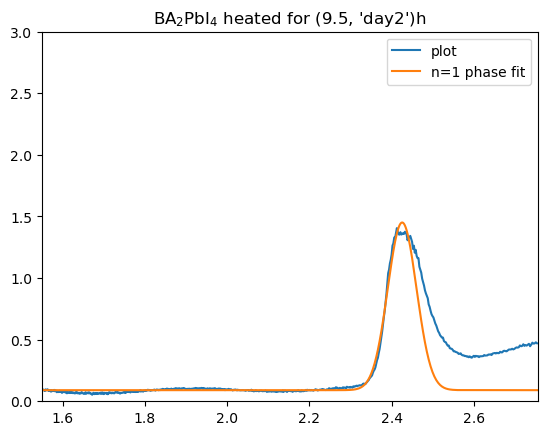

FWHM = 0.0412 ± 0.0004
x0 = 2.4255 ± 0.0004
A = 1.3614 ± 0.0071
y0 = 0.0901 ± 0.0021


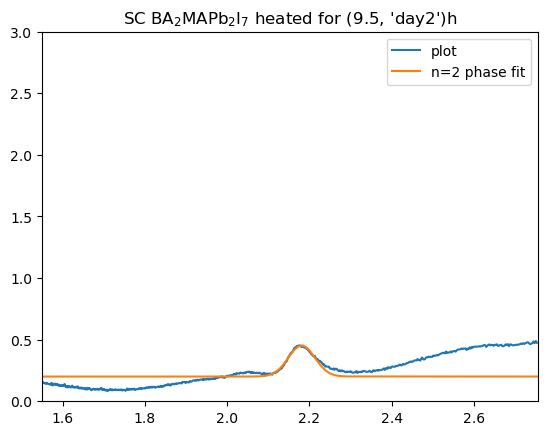

FWHM = 0.0381 ± 0.0009
x0 = 2.1812 ± 0.0003
A = 0.2511 ± 0.0046
y0 = 0.2008 ± 0.0048


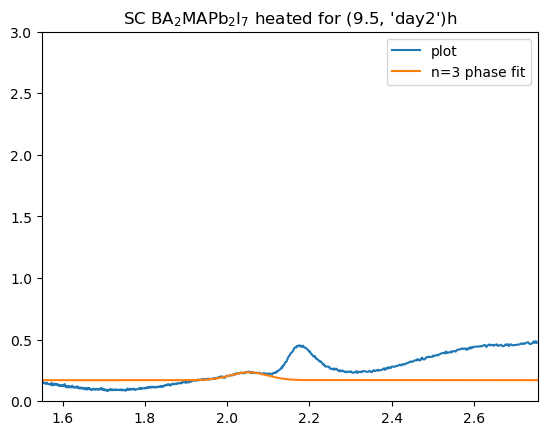

FWHM = 0.0532 ± 0.0087
x0 = 2.0532 ± 0.0016
A = 0.0636 ± 0.0120
y0 = 0.1714 ± 0.0123


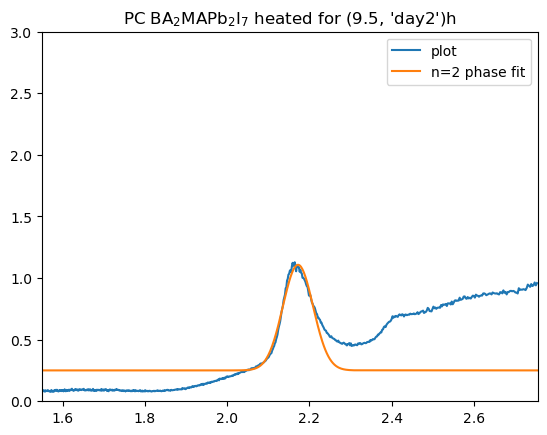

FWHM = 0.0432 ± 0.0008
x0 = 2.1723 ± 0.0004
A = 0.8572 ± 0.0105
y0 = 0.2506 ± 0.0090


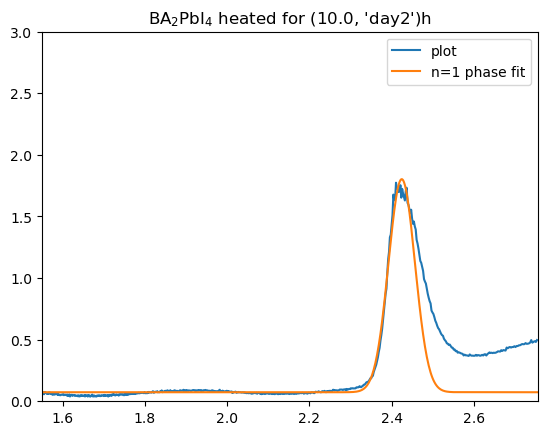

FWHM = 0.0379 ± 0.0004
x0 = 2.4244 ± 0.0003
A = 1.7300 ± 0.0088
y0 = 0.0734 ± 0.0025


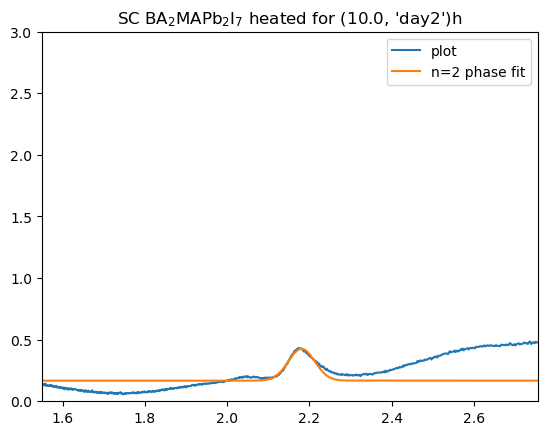

FWHM = 0.0378 ± 0.0010
x0 = 2.1810 ± 0.0004
A = 0.2584 ± 0.0055
y0 = 0.1673 ± 0.0058


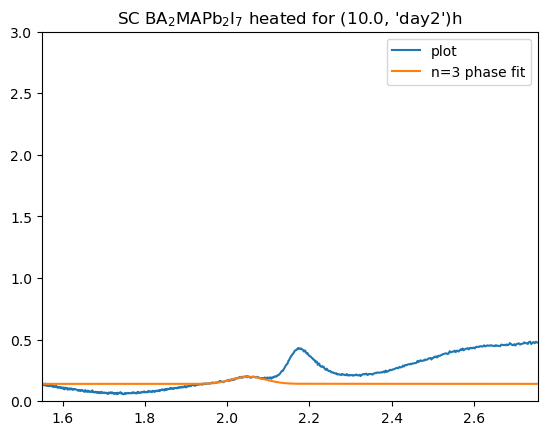

FWHM = 0.0479 ± 0.0062
x0 = 2.0532 ± 0.0014
A = 0.0579 ± 0.0077
y0 = 0.1413 ± 0.0080


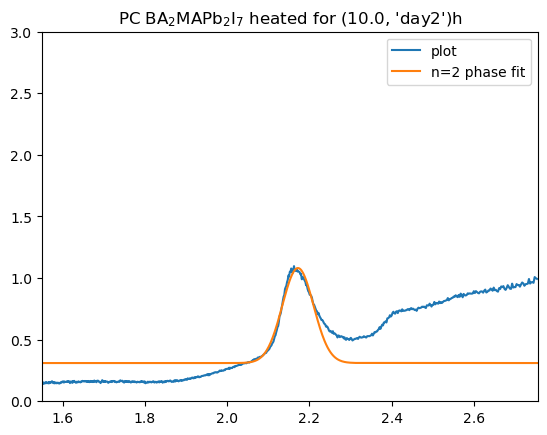

FWHM = 0.0446 ± 0.0008
x0 = 2.1722 ± 0.0004
A = 0.7709 ± 0.0095
y0 = 0.3104 ± 0.0084
Optimisation parameters stored


In [191]:
ba2pbi4_parameters3, sc_n2_parameters3, sc_n3_parameters3, pc_parameters3 = InNominePatrisEtFiliiEtSpiritusSancti(data_dict3,
                                                                                                              q1min=2,
                                                                                                              q1max=2.45,
                                                                                                              q2min=2.1,
                                                                                                              q2max=2.225,
                                                                                                              q3min=1.985,
                                                                                                              q3max=2.075,
                                                                                                              q4min=2.05,
                                                                                                              q4max=2.225,
                                                                                                                  GraphOn=True,
                                                                                                                  ParamsOn=True)

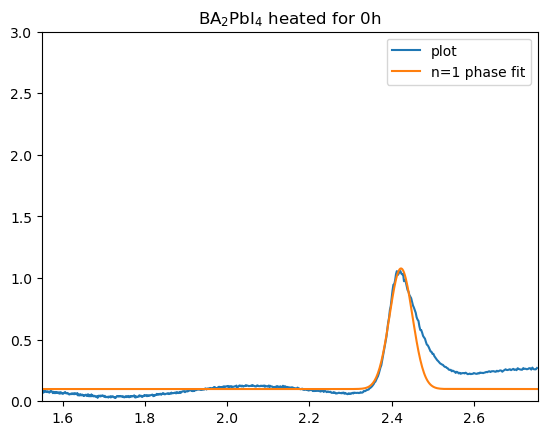

FWHM = 0.0328 ± 0.0004
x0 = 2.4226 ± 0.0003
A = 0.9790 ± 0.0069
y0 = 0.0994 ± 0.0018


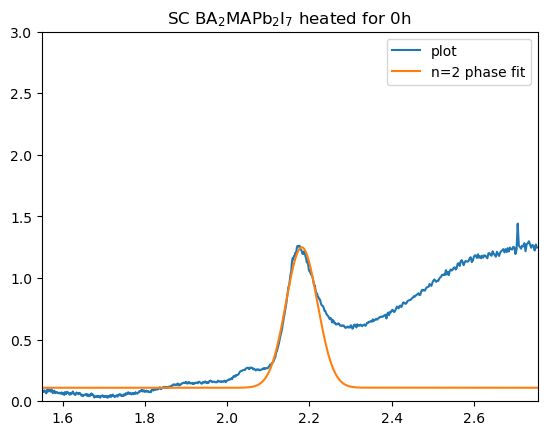

FWHM = 0.0450 ± 0.0015
x0 = 2.1814 ± 0.0004
A = 1.1398 ± 0.0331
y0 = 0.1098 ± 0.0357


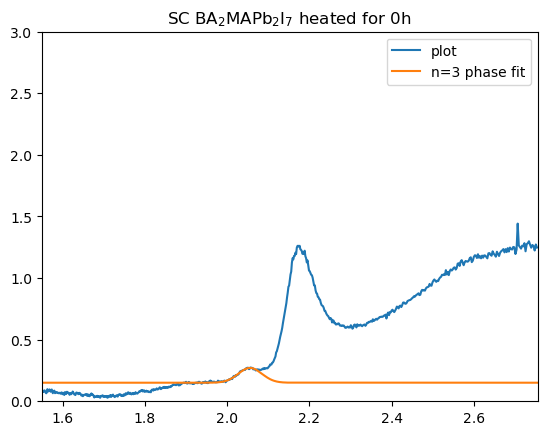

FWHM = 0.0339 ± 0.0013
x0 = 2.0559 ± 0.0006
A = 0.1201 ± 0.0028
y0 = 0.1507 ± 0.0030


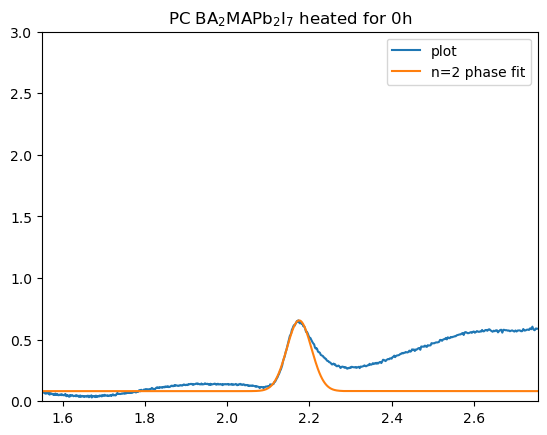

FWHM = 0.0352 ± 0.0006
x0 = 2.1752 ± 0.0002
A = 0.5737 ± 0.0058
y0 = 0.0824 ± 0.0063
Optimisation parameters stored


In [192]:
ba2pbi4_parameters4, sc_n2_parameters4, sc_n3_parameters4, pc_parameters4 = InNominePatrisEtFiliiEtSpiritusSancti(data_dict4,
                                                                                                                  q1min=2,
                                                                                                                  q1max=2.45,
                                                                                                                  q2min=2.1,
                                                                                                                  q2max=2.225,
                                                                                                                  q3min=1.985,
                                                                                                                  q3max=2.075,
                                                                                                                  q4min=2.1,
                                                                                                                  q4max=2.2,
                                                                                                                    GraphOn=True,
                                                                                                                    ParamsOn=True)

In [197]:
#plotting
print(ba2pbi4_parameters1)
print(ba2pbi4_parameters3)
print(ba2pbi4_parameters4)

[['0', 0.0352766012271899, 0.00020854697860129908, 2.4244419777257784, 0.0001677506505378795, 1.8122355674153494, 0.005829074520834389, 0.1076595704149692, 0.0015582994622862331], ['1', 0.03703588351051519, 0.0002439705269013665, 2.425779377771167, 0.00020314128073691678, 1.5423689651014234, 0.005199786770750027, 0.1031172025536698, 0.0014267108278459908]]
[[(0.0, 'day1'), 0.036112688514918716, 0.0003064677590561215, 2.425407328628834, 0.0002516404968185437, 1.869739230605668, 0.008316792947791743, 0.09429438775159213, 0.002250443331129364], [(0.5, 'day1'), 0.03490991785686839, 0.0002635360843026866, 2.424331135091506, 0.0002110004383738907, 2.084712579244419, 0.008640678372744926, 0.057063936484353636, 0.0022963364026795338], [(1.0, 'day1'), 0.03708772462581147, 0.00032295284894798797, 2.425099224078873, 0.00026642475555007885, 1.90877445739842, 0.00863709474988687, 0.05615265949237995, 0.0023746372026869993], [(1.5, 'day1'), 0.0354918277512045, 0.0002920739698479621, 2.42430751723331